# Exercise 20: Classification of LIGO data

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.

---


In [2]:
from __future__ import print_function
import numpy as np
import pylab as plt
import h5py
import corner
from cycler import cycler
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from astroML.utils import pickle_results

%config InlineBackend.figure_format='retina'

In [3]:
file = '../../temp/LIGO_data.h5'
data = h5py.File(file, 'r')

In [4]:
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [5]:
X=[]
keys = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z']
number_of_points = int(1e5)

for key  in keys:
    X.append(data[key][:number_of_points])
    
X = np.array(X).T
y = np.array(data['det'][:number_of_points])


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=404)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

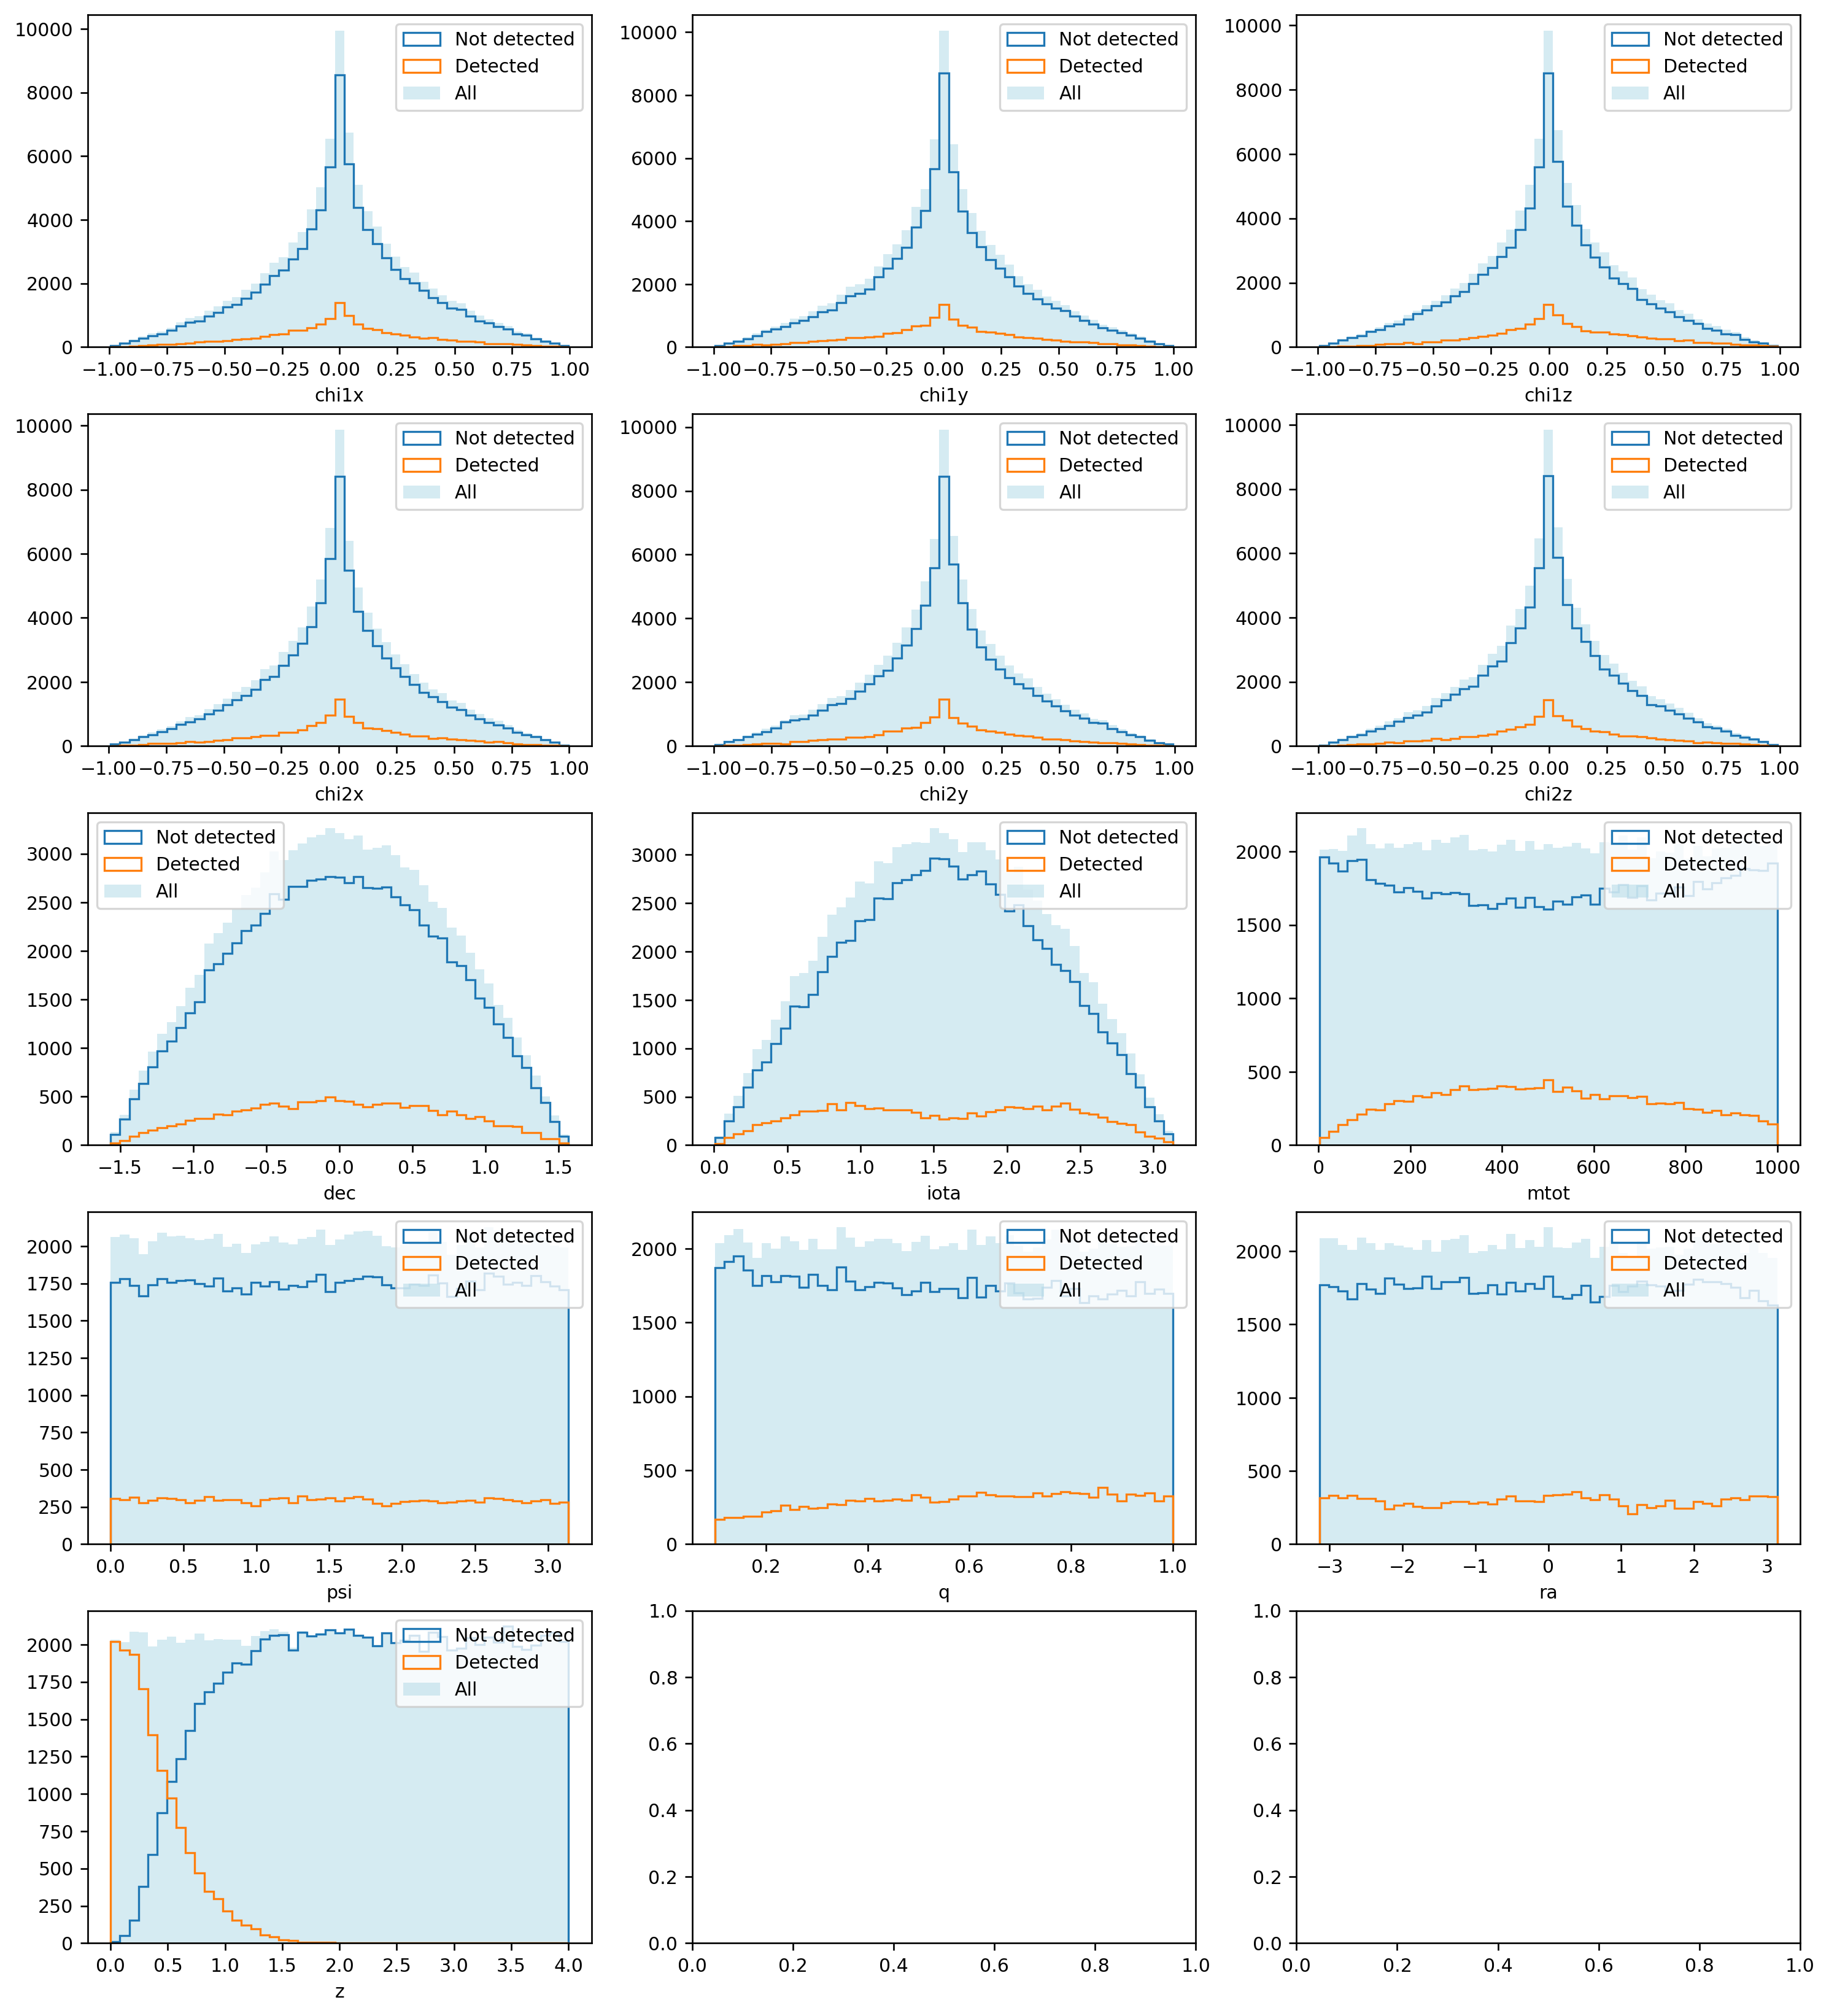

In [6]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(15,17), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(5,3)

bins = np.linspace(-0.5, 3, 100)

for ax,feature, name in zip(axs.flatten() ,X.T, keys):
    bins = np.linspace(np.min(feature), np.max(feature), 50)
    ax.hist(feature[y==0], bins=bins, histtype = 'step', label = 'Not detected', lw=1)
    ax.hist(feature[y==1], bins=bins, histtype = 'step', label = 'Detected', lw=1)
    ax.hist(feature, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    
plt.tight_layout;

From the distributions it seems that the most informative features for a classifier are:
- z
- mtot
- q
- iota
- ra

Other features have basically identical distributions for detectable and not detectable sources.

In [63]:
# data set of only useful features
Z=[]
keys_z = ['z', 'mtot', 'q', 'iota', 'ra']
number_of_points = int(1e5)

for key  in keys_z:
    Z.append(data[key][:number_of_points])
    
Z = np.array(Z).T
yz = np.array(data['det'][:number_of_points])

In [64]:
scalerz = StandardScaler()


Z_train, Z_test, yz_train, yz_test = train_test_split(Z, yz, test_size=0.3, random_state=42)

Z_train = scalerz.fit_transform(Z_train)
Z_test = scalerz.transform(Z_test)

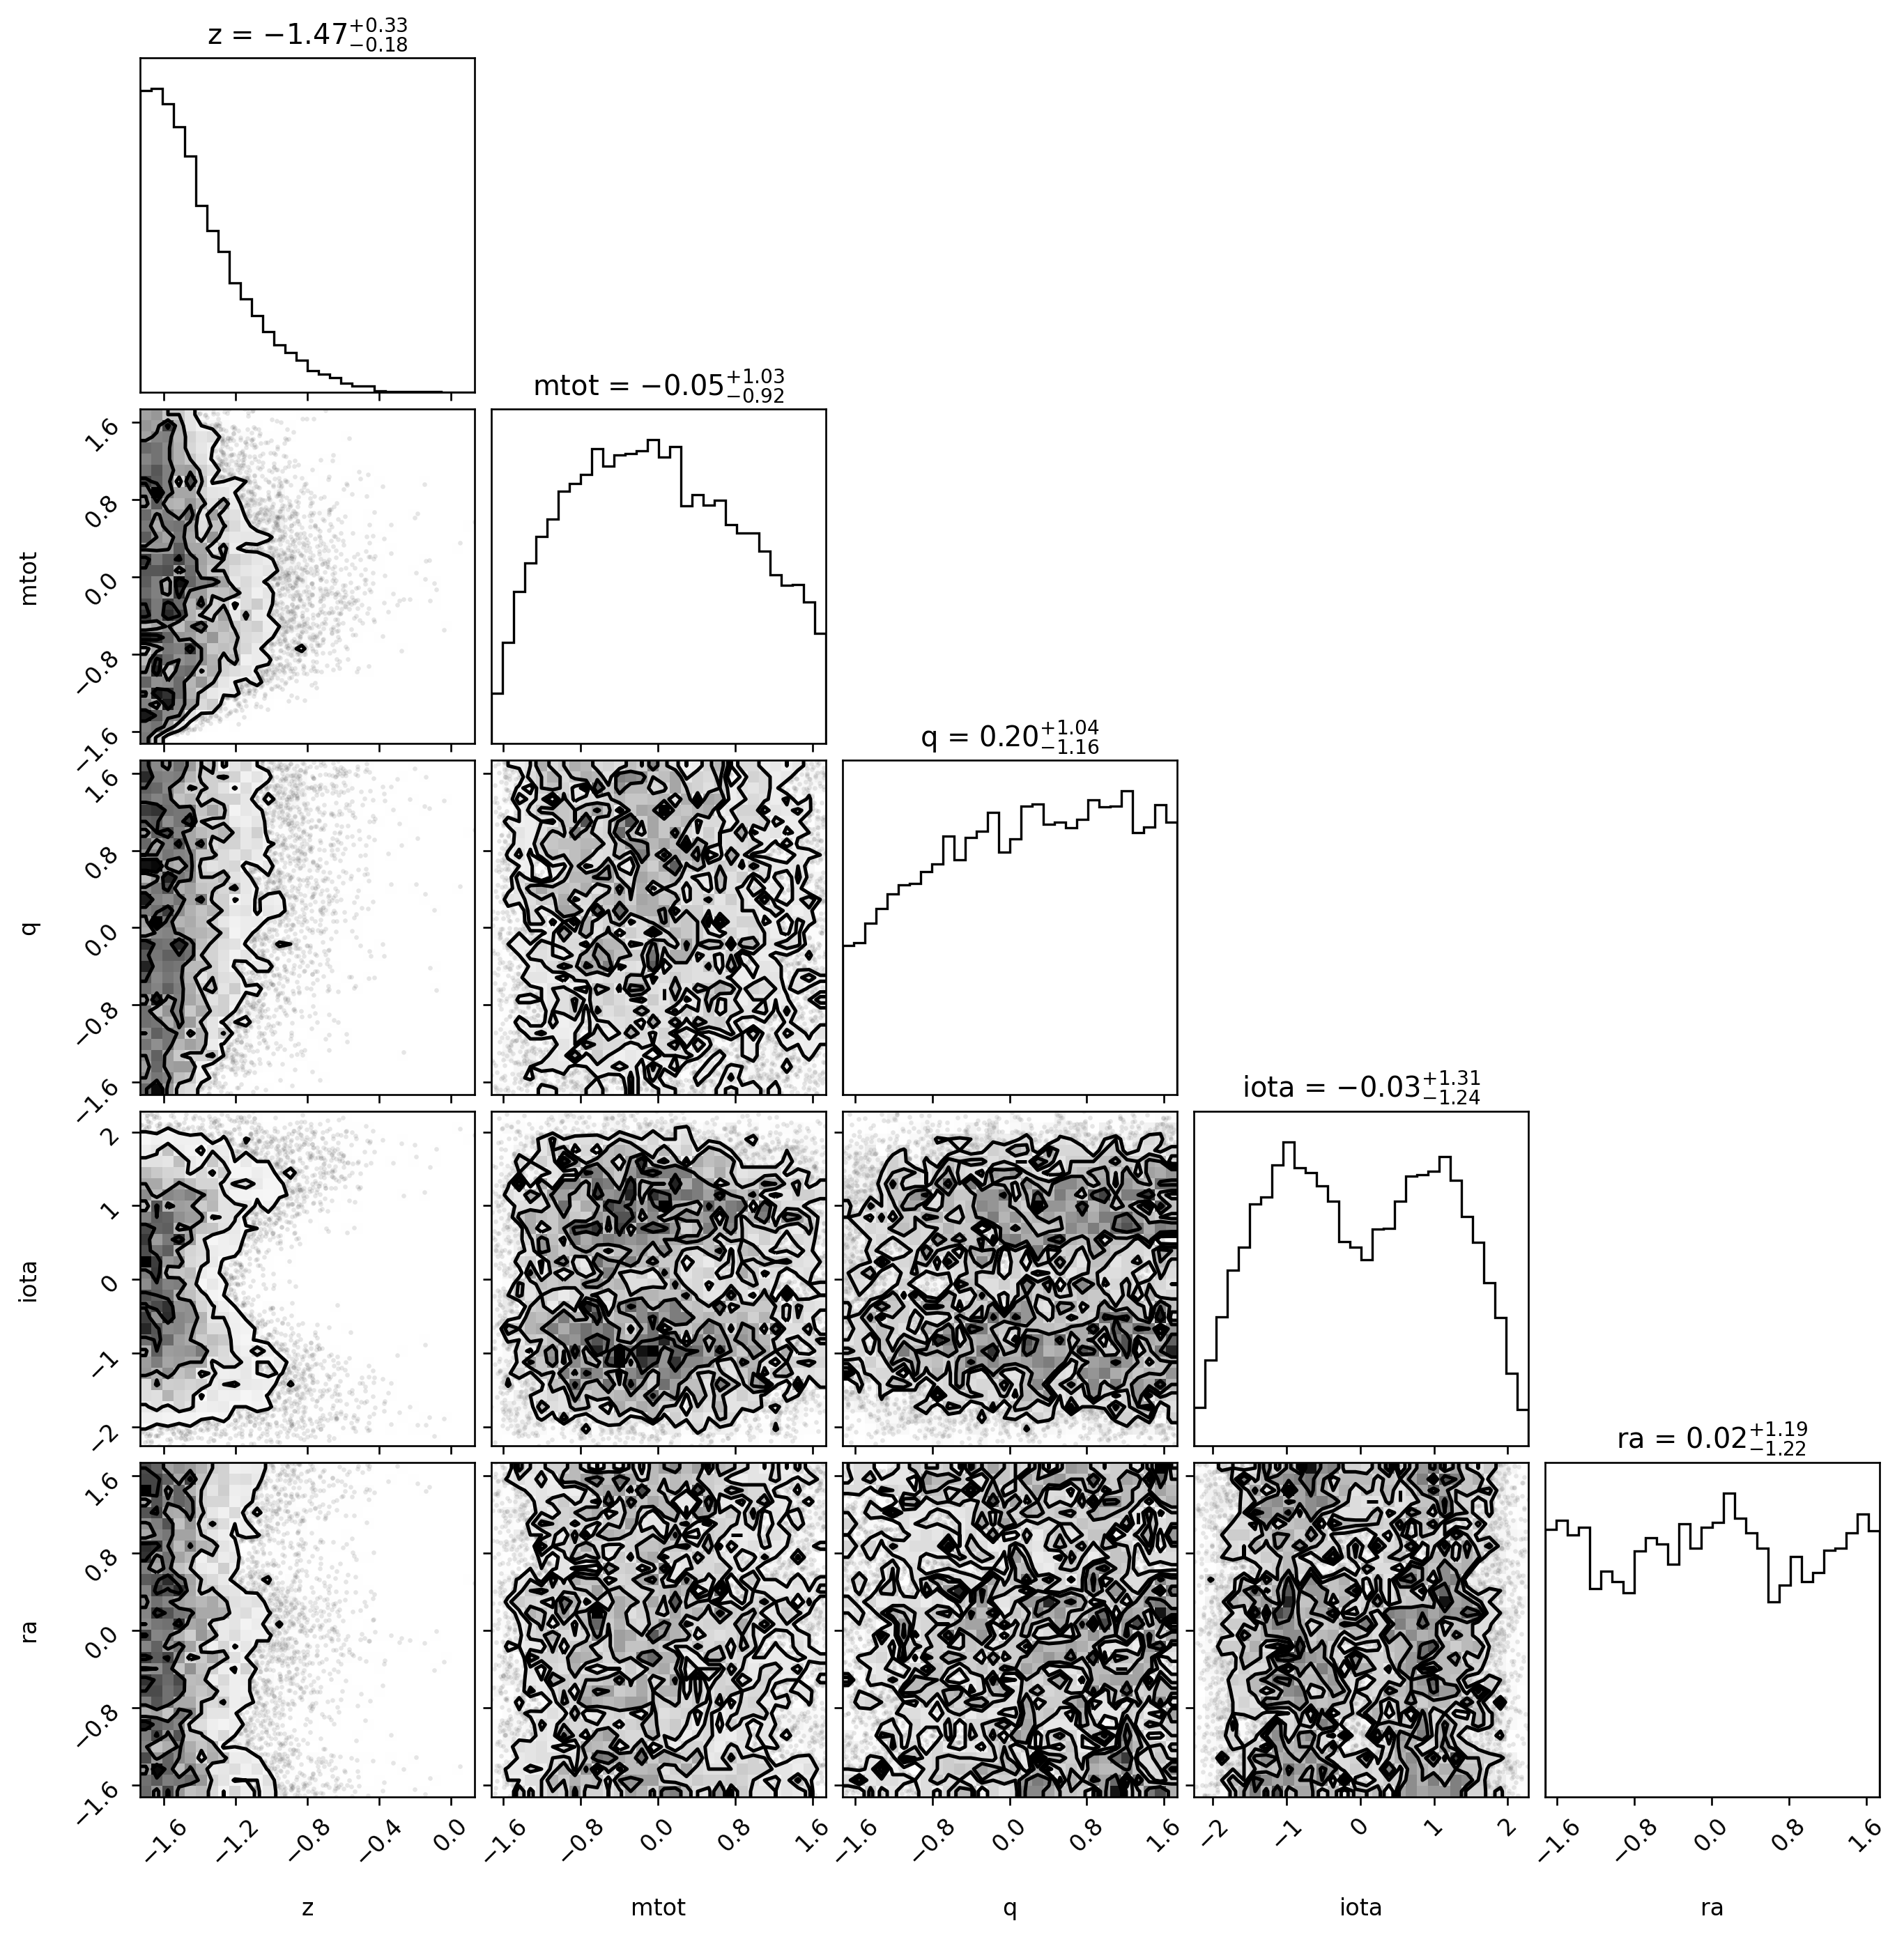

In [69]:
corner.corner(Z_train[yz_train==1], labels=keys_z, show_titles=True, bins=30);
# corner.corner(X, labels = keys, show_titles=True);


No particular correlations are found between features for both detectable and not-detectable sources.

---

## PCA
Try PCA to ease classification

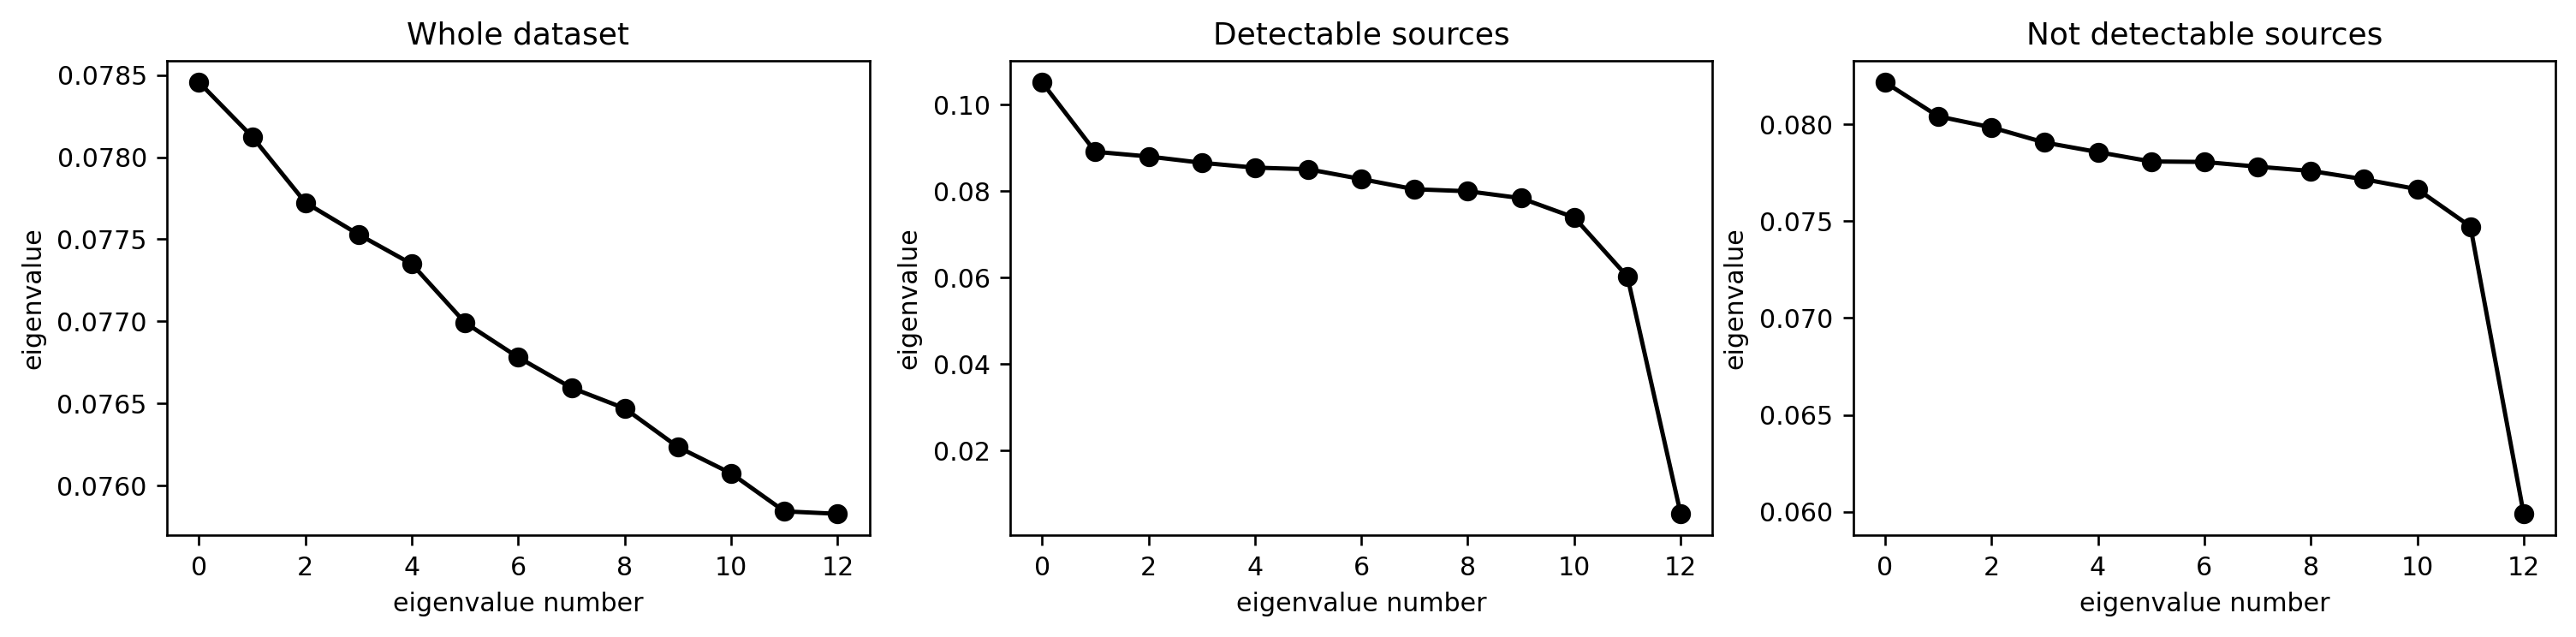

In [9]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(15,3), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,3)

n_components = len(X[0,:])

pca = PCA(n_components = n_components, svd_solver='full')

pca.fit(X_train)
evals = pca.explained_variance_ratio_ 
ax[0].plot(np.arange(n_components), evals, '-ok')
ax[0].set_xlabel('eigenvalue number')
ax[0].set_ylabel('eigenvalue')
ax[0].set_title('Whole dataset')

pca.fit(X_train[y_train==1])
evals = pca.explained_variance_ratio_ 
ax[1].plot(np.arange(n_components), evals, '-ok')
ax[1].set_xlabel('eigenvalue number')
ax[1].set_ylabel('eigenvalue')
ax[1].set_title('Detectable sources')

pca.fit(X_train[y_train==0])
evals = pca.explained_variance_ratio_ 
ax[2].plot(np.arange(n_components), evals, '-ok')
ax[2].set_xlabel('eigenvalue number')
ax[2].set_ylabel('eigenvalue')
ax[2].set_title('Not detectable sources')

plt.tight_layout;

It seems PCA is not effective to reduce dimensionality: every PCA feature explains the same amount of variance.

---

## Classification
We use default hyperparameters becaus cross-validation takes a long time, we try to implement it at the end.

In [54]:
# USEFUL FUNCTIONS
###################################################

def run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier.
    
    Use kwarg name= 'custom_name' to use custom name.
    
    Use kwarg proba = False if using a SVC - like classifier (which does not have .predict_proba() method)
    

    Use
    
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    '''
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    
    print(f'Fitting {name}')

    clf.fit(X_train, y_train)
    
    if proba == False:
        y_probs = clf.decision_function(X_test)
    else:
        y_probs = clf.predict_proba(X_test)[:, 1]
        
    y_pred = clf.predict(X_test)
    
    complet = recall_score(y_test, y_pred)
    contam = 1 - precision_score(y_test, y_pred)
    accur = accuracy_score(y_test, y_pred)
    
    metrics = np.array([accur, complet, contam])
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list (classifiers_list, **kwargs):
    '''
    DO NOT USE WITH SVC etc (without .predict_proba() method): use run_classifier() on the single clf and then append info manually
    Trains and evalutate performance of a list of classifiers
    Use kwarg names= ['name1','name2',..] to use custom name list for classifiers
    
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function'''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier(clf, name=name))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    '''
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9,3), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0.9, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.9, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(11,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        
        margins = [0.05,0.05,0.05]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics in zip(names, metrics_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]) - margins[i], np.max(metrics_arr[i] + margins[i] )) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

if False:
# To do everything in one go
    def evaluate_classifiers(clf_list, names, plot_curves = True, plot_metrics_bars = True): 
        '''
        Trains and compares different classifiers.
        
        Input: List of classifiers, list of names
        Output: metrics pd.DataFrame and list of classifier params
        If plot = True (default) plots ROC and precision-recall curves
        '''
        info_list = []
        
        for clf,name in zip(clf_list,names): # Run classifiers using above funciton
            info = run_classifier(clf,name)
            info_list.append(info)
            
        metrics_dataframe, params_list = compare_classifiers(info_list, plot_curves, plot_metrics_bars)
                    
        return metrics_dataframe, params_list


In [94]:
clf_svc_rbf = SVC(kernel='rbf', cache_size = 2000)
clf_svc_poly = SVC(kernel='poly', cache_size = 2000)
clf_svc_sig = SVC(kernel='sigmoid', cache_size = 2000)

clf_dtc = DecisionTreeClassifier()
clf_rdf = RandomForestClassifier()
clf_bag = BaggingClassifier(n_jobs=-1) 
clf_ada = AdaBoostClassifier()

clf_list = [clf_dtc, clf_rdf, clf_bag, clf_ada]
svc_list = [clf_svc_rbf, clf_svc_poly, clf_svc_sig ]


In [95]:
info_list1 = run_classifier_list(clf_list)

Fitting DecisionTreeClassifier()
Fitting RandomForestClassifier()
Fitting BaggingClassifier(n_jobs=-1)
Fitting AdaBoostClassifier()


In [96]:
svc_info_list = []
for svc in svc_list:
    info = run_classifier(svc, proba = False )
    svc_info_list.append(info)

Fitting SVC(cache_size=2000)
Fitting SVC(cache_size=2000, kernel='poly')
Fitting SVC(cache_size=2000, kernel='sigmoid')


In [97]:
info_list_tot = info_list1 + svc_info_list

name  accuracy  completeness  \
4                    SVC(cache_size=2000)  0.966400      0.873735   
5     SVC(cache_size=2000, kernel='poly')  0.964400      0.837856   
1                RandomForestClassifier()  0.964367      0.841996   
2            BaggingClassifier(n_jobs=-1)  0.962533      0.833027   
3                    AdaBoostClassifier()  0.961033      0.836477   
0                DecisionTreeClassifier()  0.949667      0.819917   
6  SVC(cache_size=2000, kernel='sigmoid')  0.886733      0.590386   

   contamination  
4       0.107797  
5       0.090614  
1       0.094484  
2       0.099005  
3       0.111844  
0       0.169385  
6       0.386472

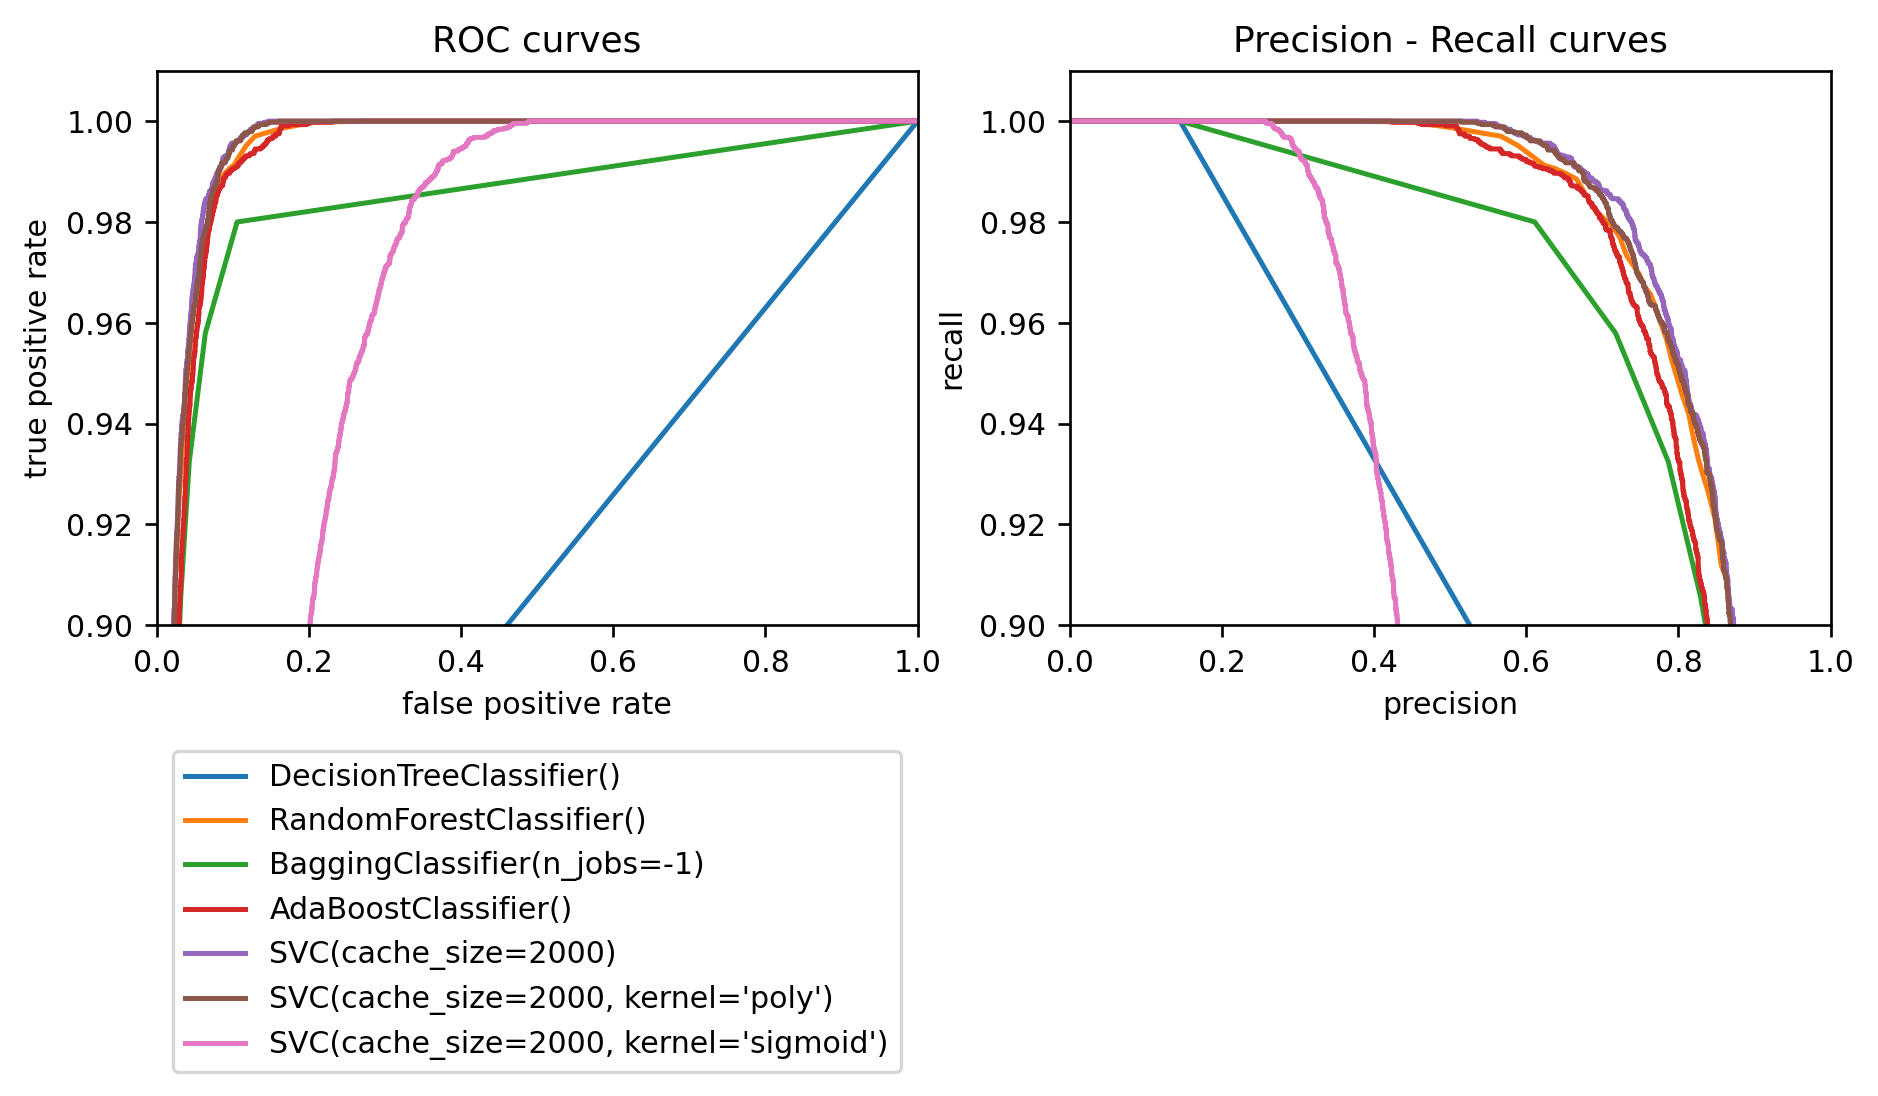

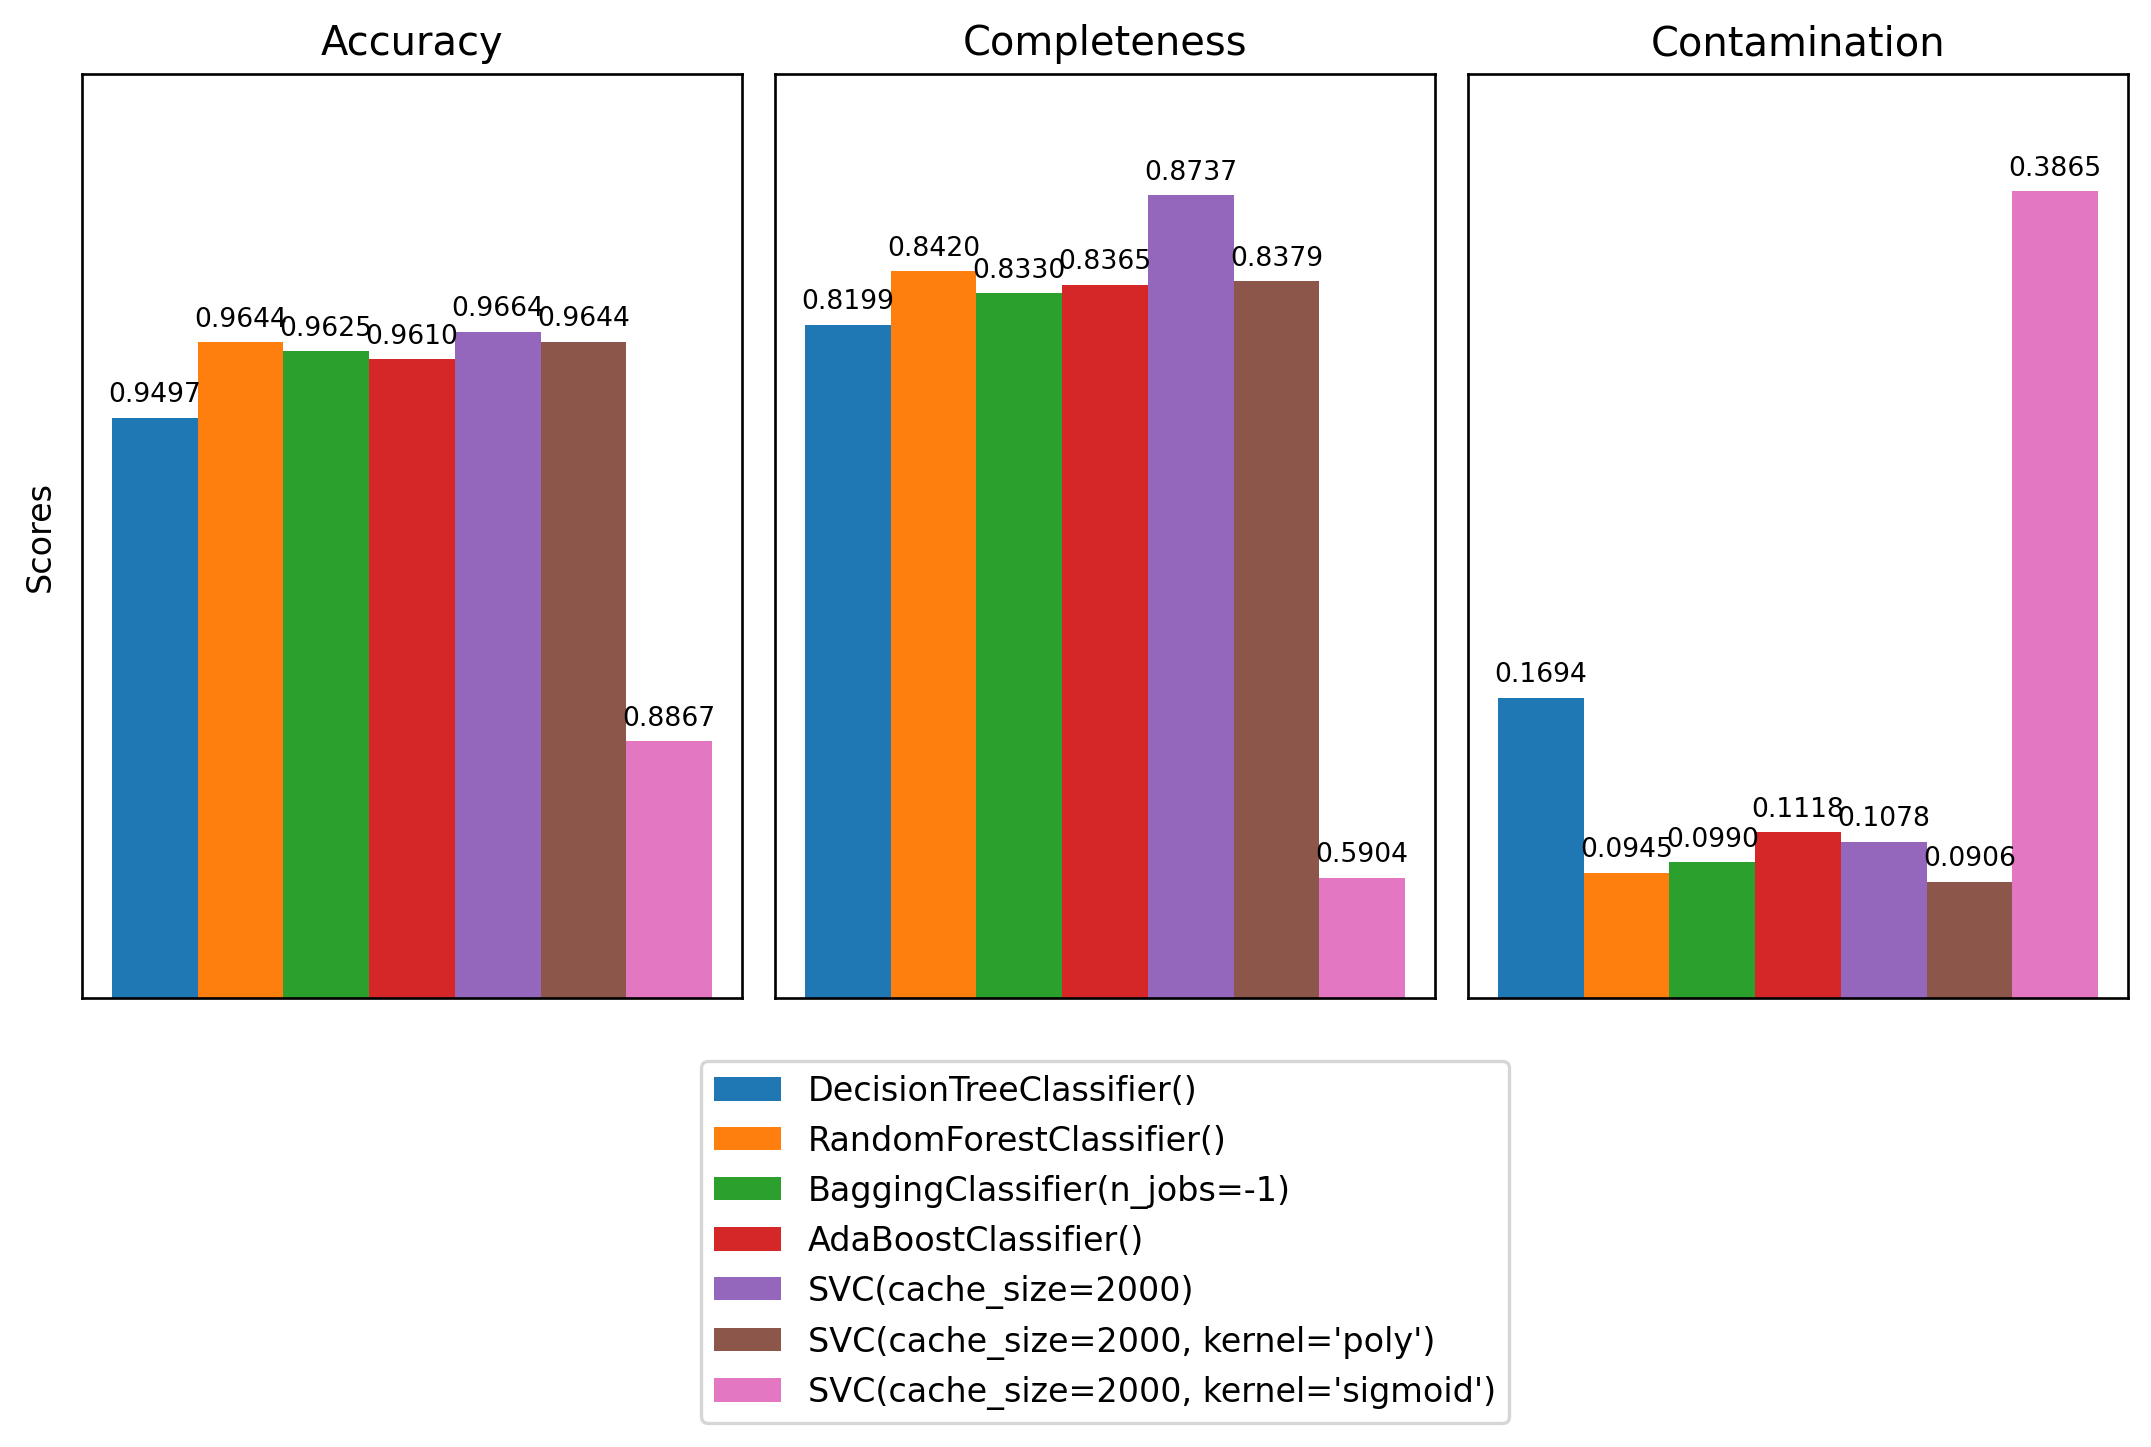

In [98]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a1 = compare_classifiers(info_list_tot )

## Reduced dataset

In [43]:
# USEFUL FUNCTIONS FOR REDUCED DATASET
###################################################

def Z_run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
    Use kwarg name = 'custom_name' to use custom name
    Use kwarg proba = False if using a SVC - like classifier (which does not have .predict_proba() method)
    
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    '''
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    
    print(f'Fitting {name}')

    clf.fit(Z_train, yz_train)
    
    if proba == False:
        y_probs = clf.decision_function(Z_test)
    else:
        y_probs = clf.predict_proba(Z_test)[:, 1]
        
    y_pred = clf.predict(Z_test)
    
    complet = recall_score(yz_test, y_pred)
    contam = 1 - precision_score(yz_test, y_pred)
    accur = accuracy_score(yz_test, y_pred)
    
    metrics = np.array([accur, complet, contam])
    
    fpr, tpr, thresh = roc_curve(yz_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(yz_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def Z_run_classifier_list (classifiers_list, **kwargs):
    '''
    Trains and evalutate performance of a list of classifiers
    Use kwarg names= ['name1','name2',..] to use custom name list for classifiers
    
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function'''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(Z_run_classifier(clf, name=name))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    '''
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9,3), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(11,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        
        margins = [0.01,0.01,0.01]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics in zip(names, metrics_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]) - margins[i], np.max(metrics_arr[i] + margins[i] )) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################

if False:
# To do everything in one go
    def evaluate_classifiers(clf_list, names, plot_curves = True, plot_metrics_bars = True): 
        '''
        Trains and compares different classifiers.
        
        Input: List of classifiers, list of names
        Output: metrics pd.DataFrame and list of classifier params
        If plot = True (default) plots ROC and precision-recall curves
        '''
        info_list = []
        
        for clf,name in zip(clf_list,names): # Run classifiers using above funciton
            info = run_classifier(clf,name)
            info_list.append(info)
            
        metrics_dataframe, params_list = compare_classifiers(info_list, plot_curves, plot_metrics_bars)
                    
        return metrics_dataframe, params_list


In [13]:
clf_svc_rbf = SVC(kernel='rbf')
clf_svc_poly = SVC(kernel='poly')
clf_dtc = DecisionTreeClassifier()
clf_rdf = RandomForestClassifier()
clf_bag = BaggingClassifier(n_jobs=-1) 
clf_ada = AdaBoostClassifier()

classifiers = [clf_svc_rbf, clf_svc_poly, clf_dtc, clf_rdf,clf_bag,clf_ada]


In [15]:
info_list_z = Z_run_classifier_list(classifiers)

Fitting SVC()
Fitting SVC(kernel='poly')
Fitting DecisionTreeClassifier()
Fitting RandomForestClassifier()
Fitting BaggingClassifier(n_jobs=-1)
Fitting AdaBoostClassifier()


name  accuracy  completeness  contamination
0                         SVC()  0.964433      0.857936       0.108868
3      RandomForestClassifier()  0.962800      0.841971       0.106336
5          AdaBoostClassifier()  0.960300      0.830403       0.113170
1            SVC(kernel='poly')  0.959867      0.823693       0.110445
4  BaggingClassifier(n_jobs=-1)  0.959700      0.821379       0.109606
2      DecisionTreeClassifier()  0.947800      0.810736       0.175917

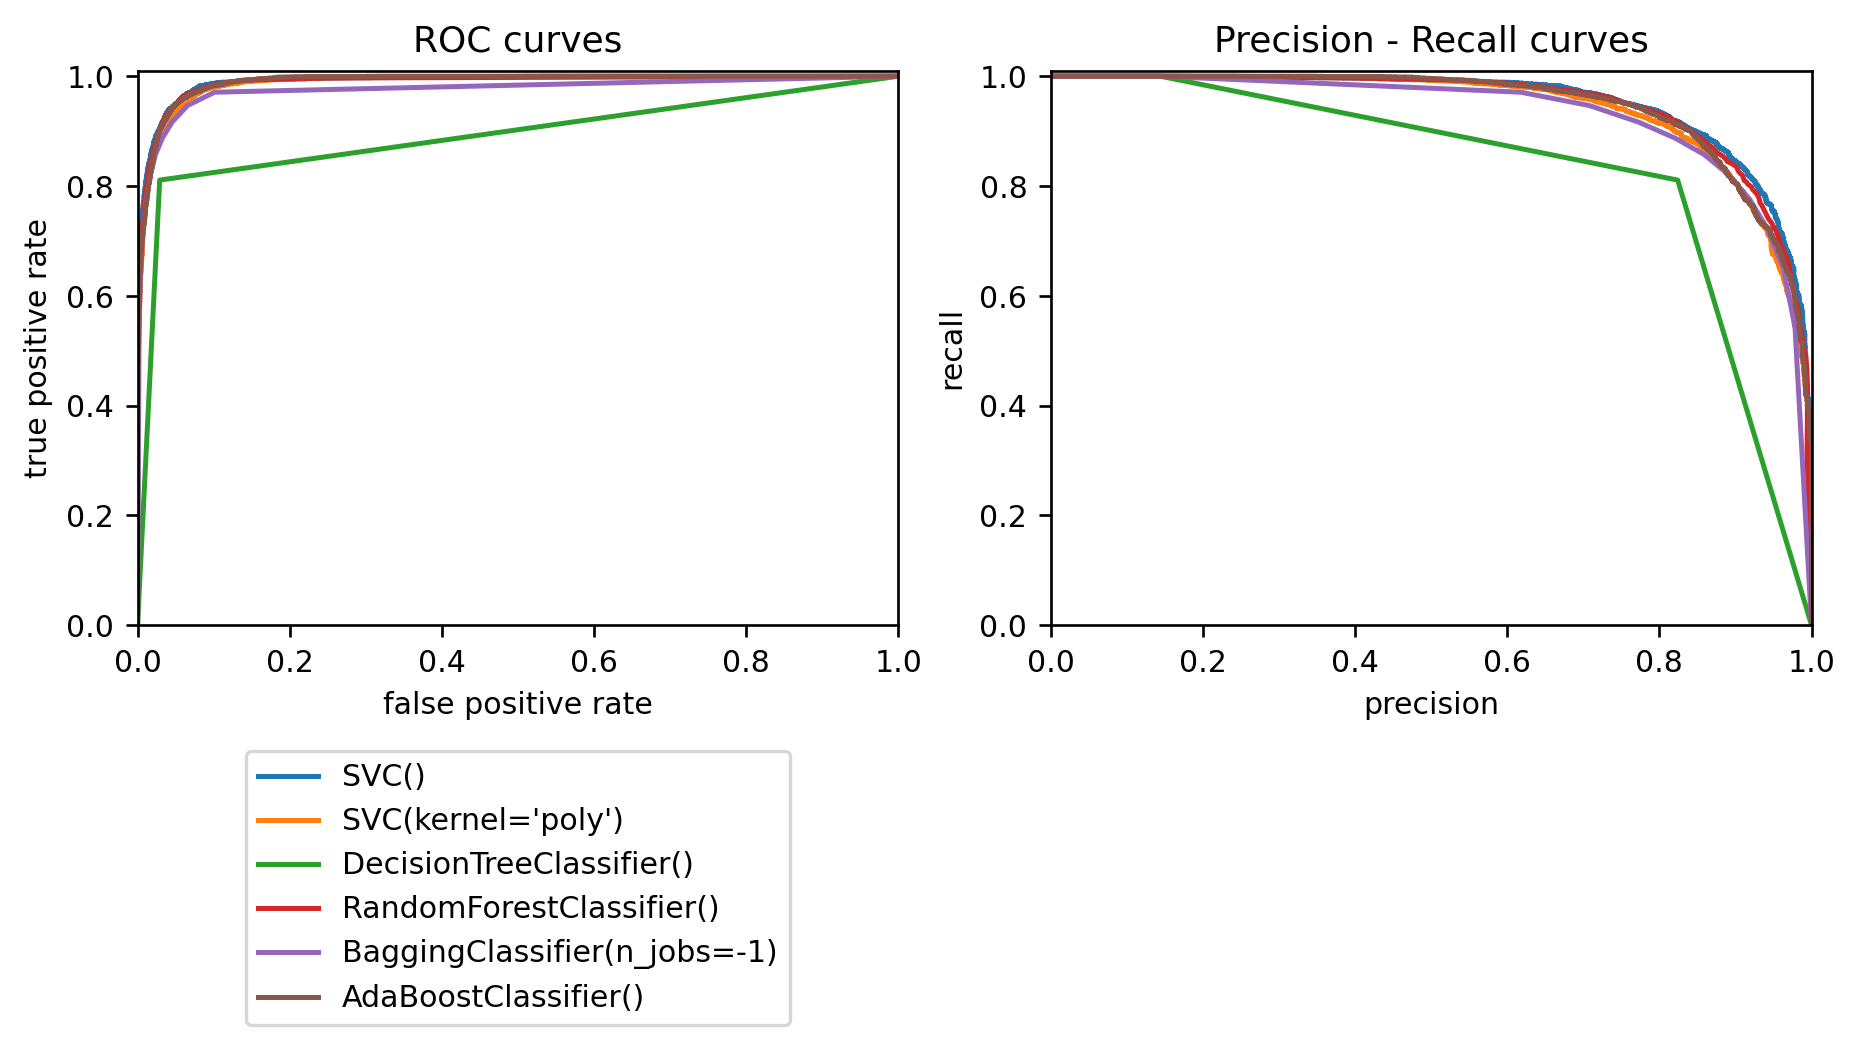

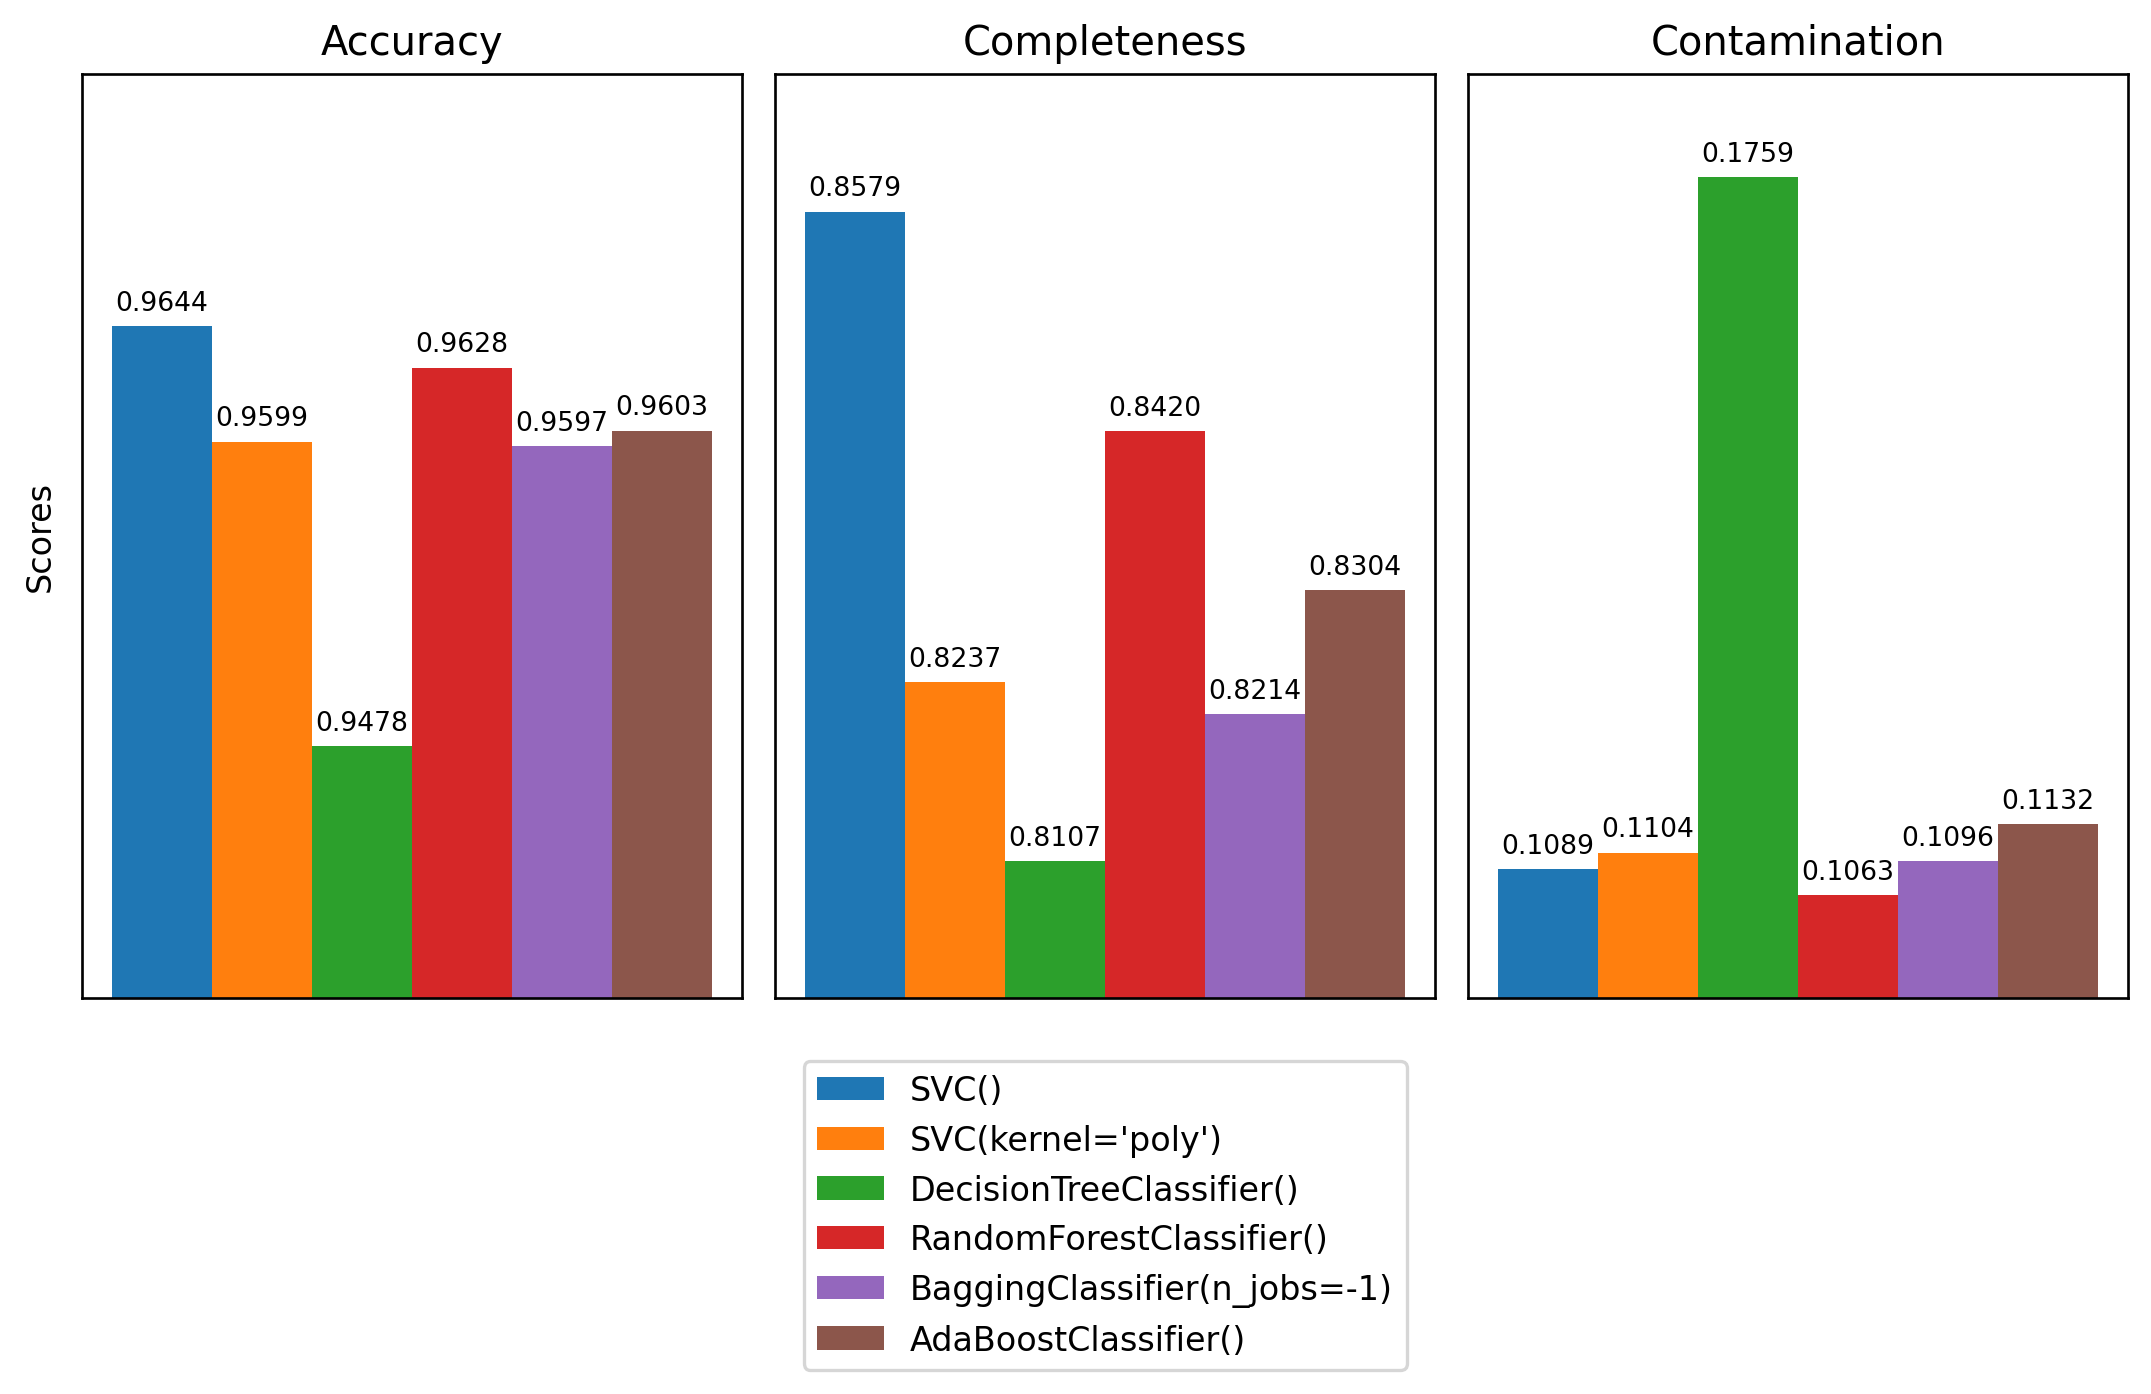

In [16]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a_z = compare_classifiers(info_list_z )

No true improvement nor worsening from using the reduced dataset.

## Cross Validation for classifiers


In [74]:
# Use reduced number of points for CV, then evaluate with full set

Xcv=[]
keys = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra','z'] 

number_of_points = int(5e4) 

for key  in keys:
    Xcv.append(data[key][:number_of_points])
    
Xcv = np.array(Xcv).T
ycv = np.array(data['det'][:number_of_points])

# Scale data after splitting to avoid information leakage

Xcv_train, Xcv_test, ycv_train, ycv_test = train_test_split(Xcv, ycv, test_size=0.3, random_state=42)

scaler_cv = StandardScaler()

Xcv_train = scaler_cv.fit_transform(Xcv_train)
Xcv_test = scaler_cv.transform(Xcv_test)



### SVC Classifier

In [37]:
# GridSearchCV for SVC, hyperparameters found by adjusting parameter grid manually

#              C = For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
#                     A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy
#  gamma = Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values 
#                     meaning ‘far’ and high values meaning ‘close’.

clf_svc_rbf = SVC(kernel='rbf', cache_size=2000 )
d_svc_rbf = {'C': np.logspace(-1, 3 , 10), 'gamma': np.logspace(-4, 0, 10)} 

grid = GridSearchCV(clf_svc_rbf, d_svc_rbf, n_jobs=-1, cv=5, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


SVC(C=359.38136638046257, cache_size=2000, gamma=0.005994842503189409)


Best parameters from cross-validation: C = 360, gamma = 0.006

In [56]:
# Now fit the estimator with best params on the whole train set, and evaluate on whole test set.

CV_svc_rbf = SVC(kernel='rbf', cache_size=2000 , C=360, gamma = 0.006 )
info_svc_rbf_CV = run_classifier(CV_svc_rbf, proba = False )

Fitting SVC(C=360, cache_size=2000, gamma=0.006)


name  accuracy  completeness  \
0  SVC(C=360, cache_size=2000, gamma=0.006)  0.966667      0.875345   
1                                     SVC()  0.966400      0.873735   

   contamination  
0       0.107411  
1       0.107797

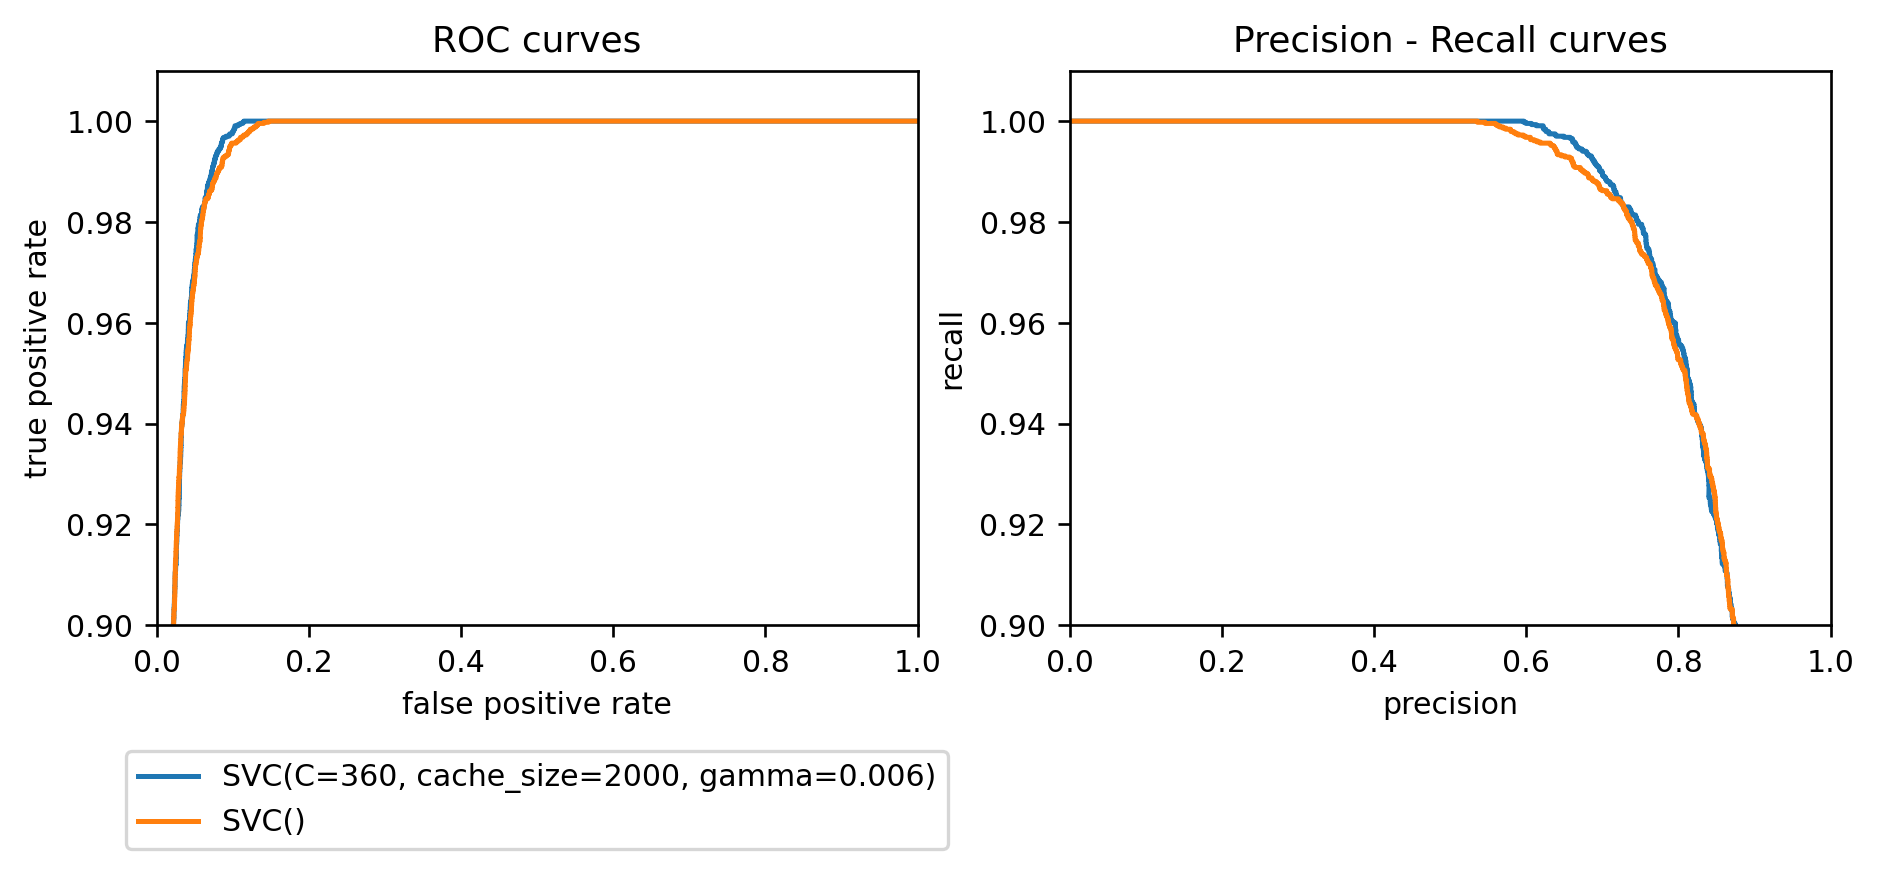

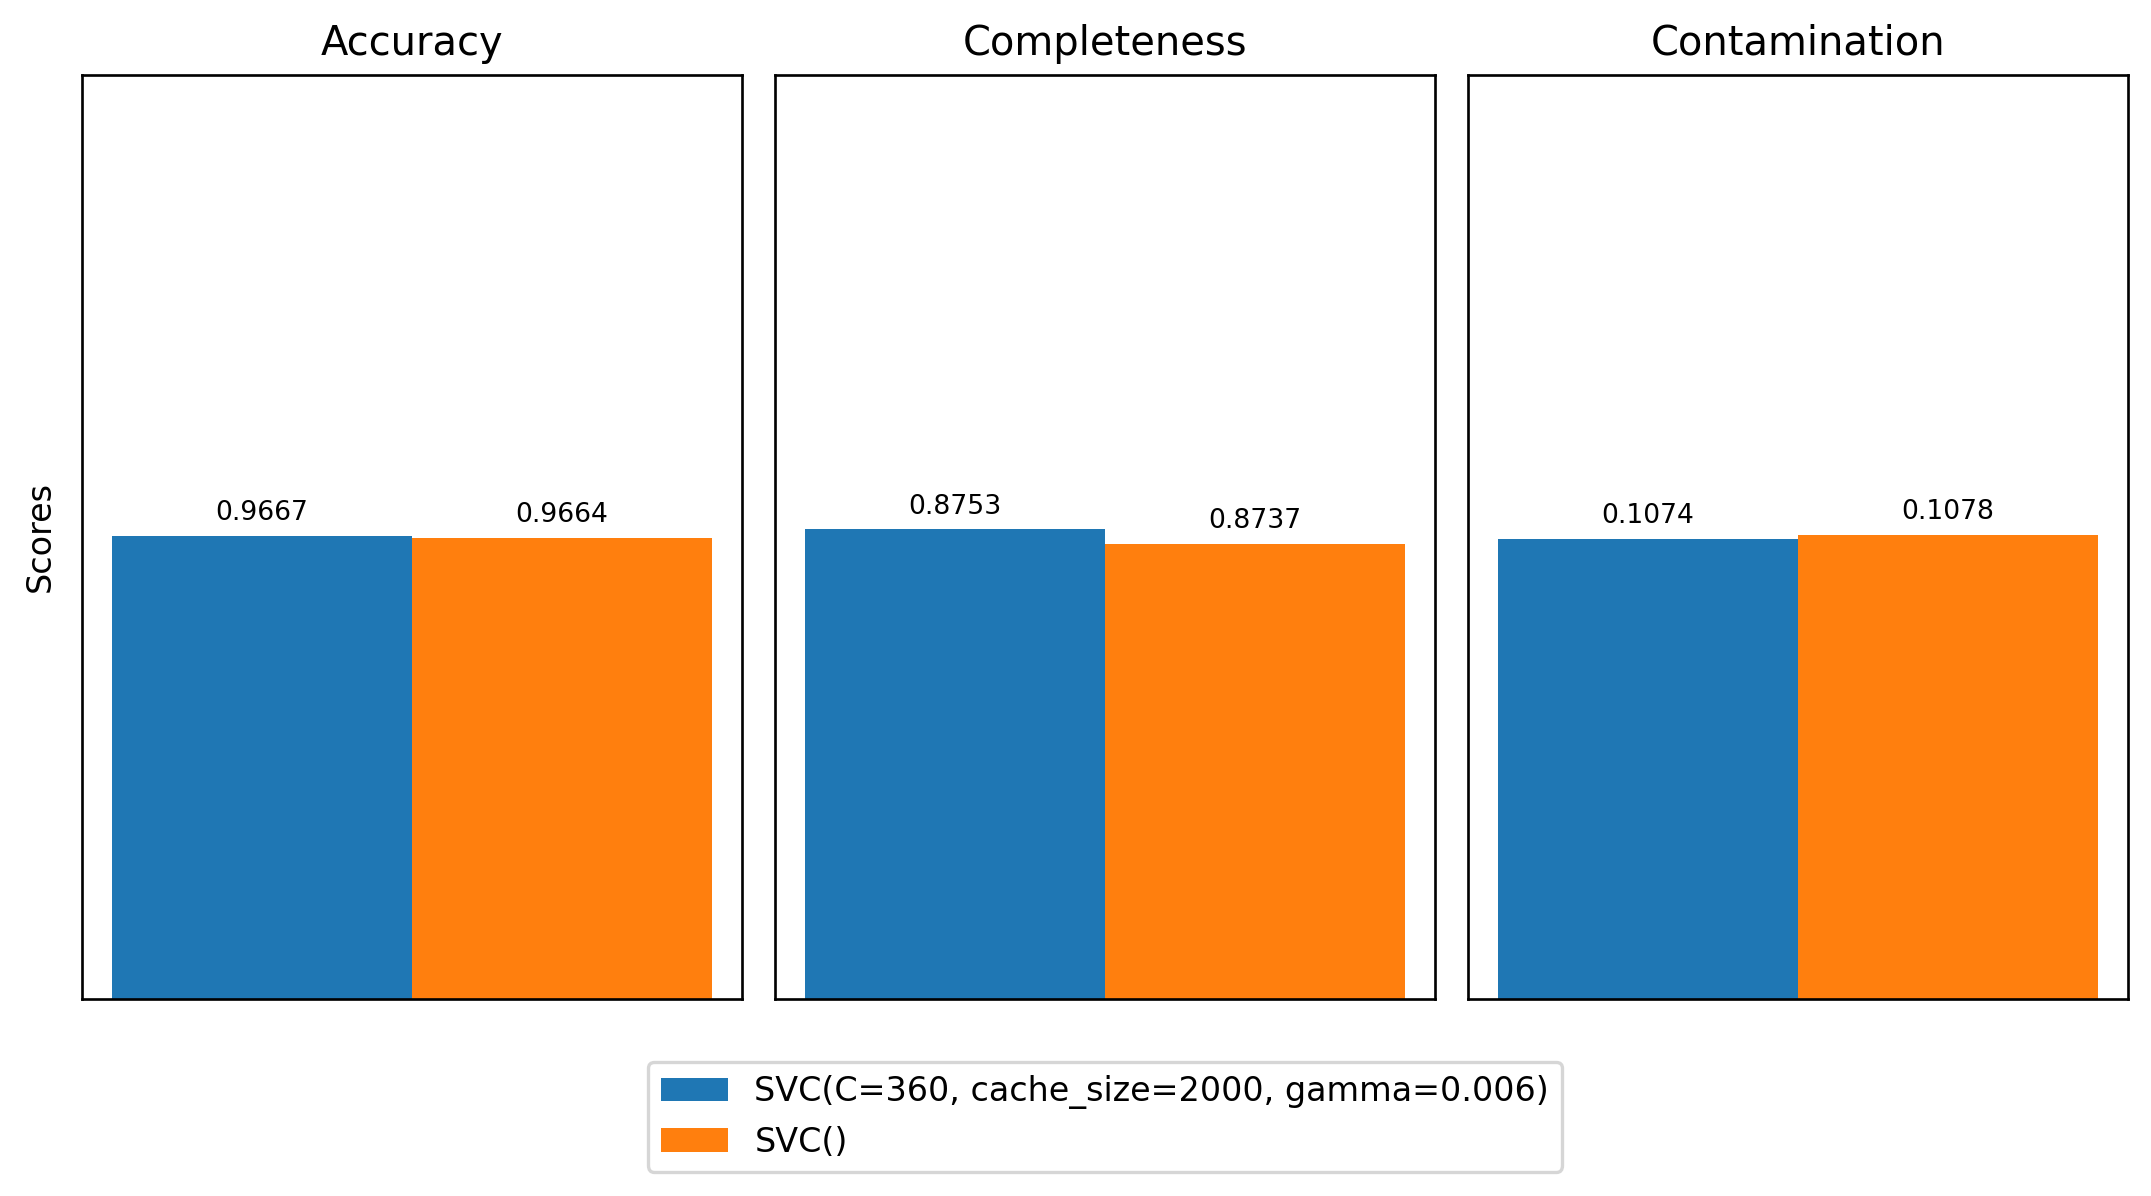

In [59]:
# Compare classifier with cross-validated parameters vs base one

info_list_rbf = [info_svc_rbf_CV] + [svc_info_list[0]]
a_rbf = compare_classifiers(info_list_rbf)

We see a slight improvement.

### DecisionTreeClassifier

In [99]:
clf_dct = DecisionTreeClassifier()
d_dct = {'criterion':['gini', 'entropy'], 'max_depth': np.arange(5,100, 5)} 

grid = GridSearchCV(clf_dct, d_dct, n_jobs=-1, cv=5, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_params_)


Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 190 out of 190 | elapsed:   15.8s finished


{'criterion': 'entropy', 'max_depth': 10}


Best parameters from cross-validation: Criterion = entropy, Max_depth = 10

In [100]:
# Now fit the estimator with best params on the whole train set, and evaluate on whole test set.

CV_dtc = DecisionTreeClassifier(criterion='entropy', max_depth=10)
info_dtc_CV = run_classifier(CV_dtc)

Fitting DecisionTreeClassifier(criterion='entropy', max_depth=10)


name  accuracy  completeness  \
0  DecisionTreeClassifier(criterion='entropy', ma...  0.956533      0.821067   
1                           DecisionTreeClassifier()  0.949667      0.819917   

   contamination  
0       0.128418  
1       0.169385

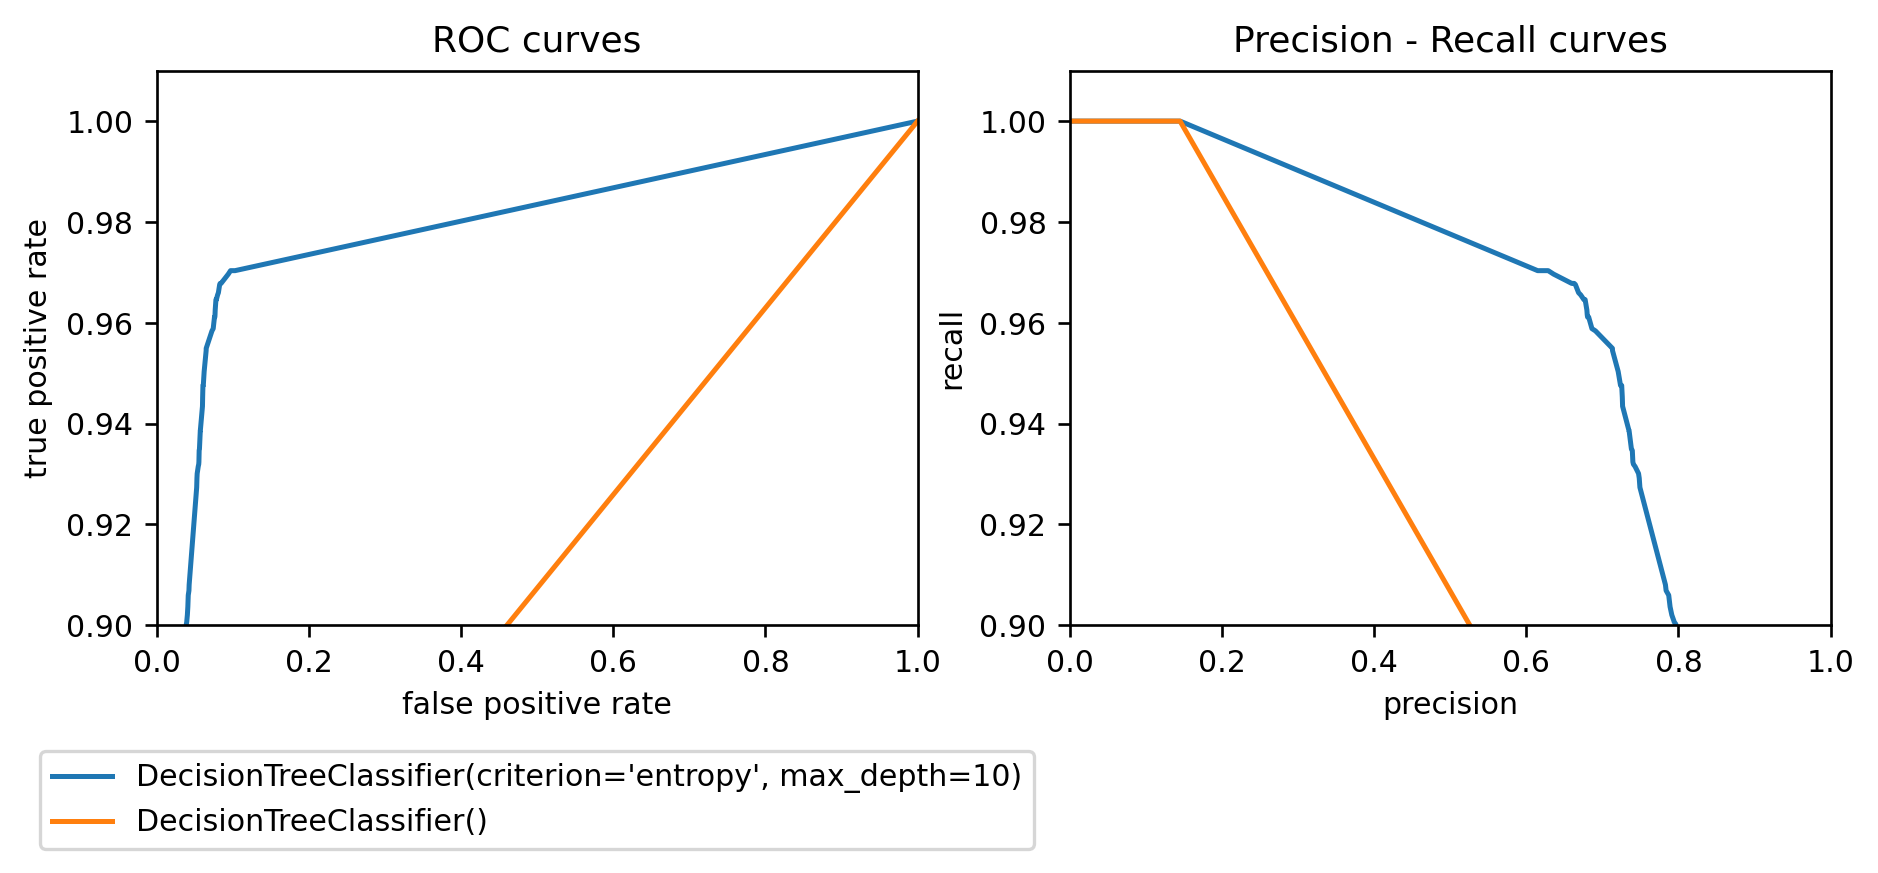

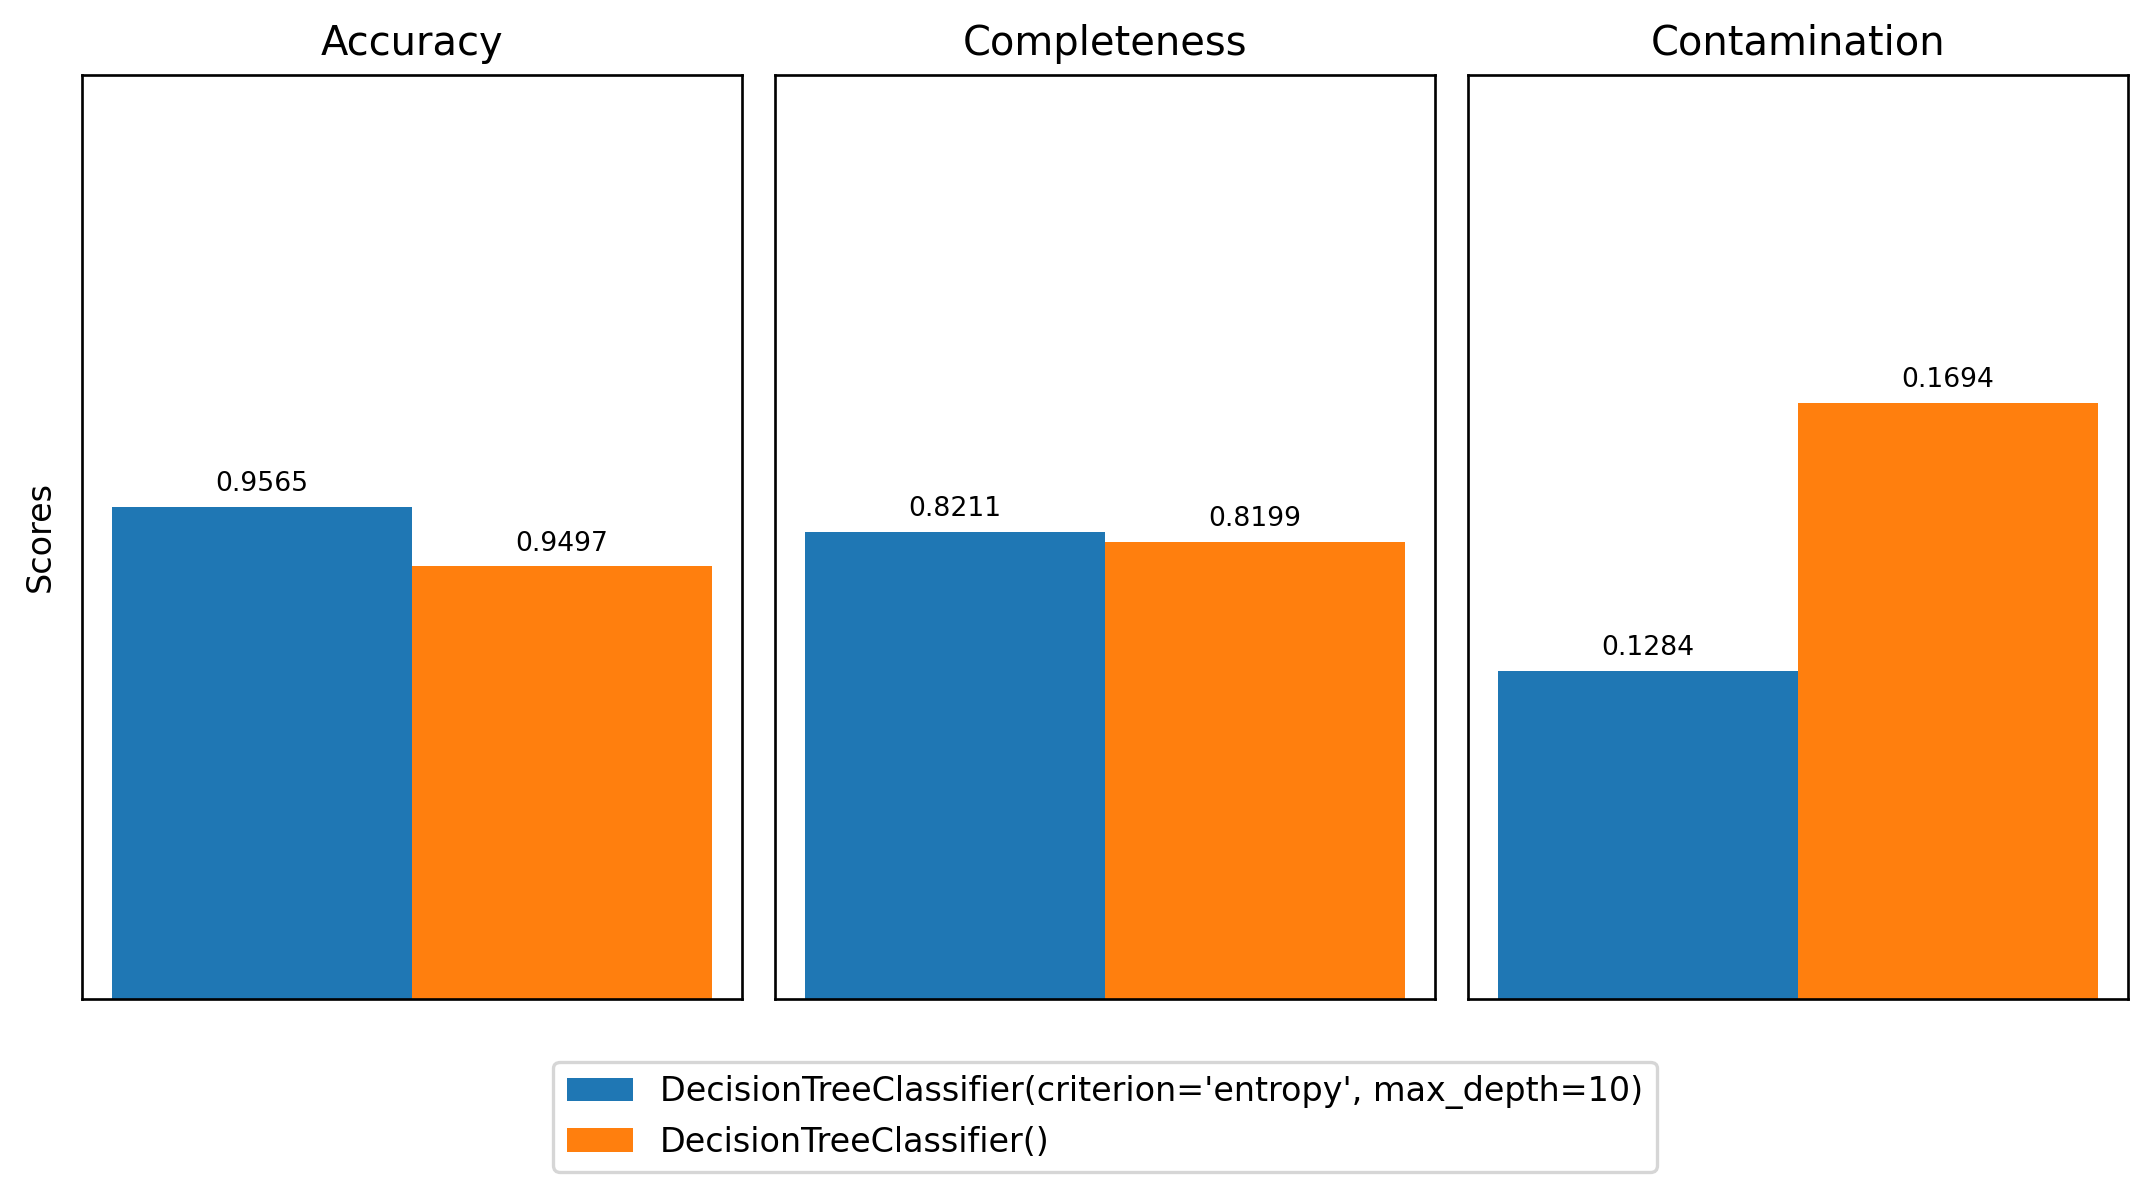

In [103]:
# Compare classifier with cross-validated parameters vs base one

info_list_dtc = [info_dtc_CV] + [info_list1[0]]
a_dtc = compare_classifiers(info_list_dtc)

Slight improvement

### RandomForest classifier

In [104]:
clf_rdf = RandomForestClassifier(n_jobs=-1)
d_rdf = {'n_estimators': np.arange(50,100,10), 'max_depth': np.arange(5,100,10)}

grid = GridSearchCV(clf_rdf, d_rdf, n_jobs=-1, cv=5, verbose=1)
grid.fit(Xcv_train,ycv_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.3min finished


RandomForestClassifier(max_depth=65, n_estimators=70, n_jobs=-1)


In [87]:
res = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score", ascending=True)
display(res)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
66       7.859955      0.156158         0.366694        0.022118   
75      18.261731      0.318248         0.483086        0.068948   
77      18.183822      0.220748         0.490482        0.033674   
71      12.750973      0.342647         0.444887        0.035083   
76      17.890571      0.583631         0.491020        0.063175   
..            ...           ...              ...             ...   
0        2.904125      0.161202         0.240023        0.062937   
6        7.363637      0.382181         0.429589        0.050399   
7        7.942065      0.108694         0.393657        0.077008   
1        3.639189      0.438529         0.344361        0.084819   
3        4.947384      0.287718         0.276164        0.147486   

   param_max_depth param_n_estimators                                 params  \
66               9                 70   {'max_depth': 9, 'n_estimators': 70}   
75               9                160  {'max_depth': 9, 'n_estimators': 160}   
77               9                180  {'max_depth': 9, 'n_estimators': 180}   
71               9                120  {'max_depth': 9, 'n_estimators': 120}   
76               9                170  {'max_depth': 9, 'n_estimators': 170}   
..             ...                ...                                    ...   
0                5                 50   {'max_depth': 5, 'n_estimators': 50}   
6                5                110  {'max_depth': 5, 'n_estimators': 110}   
7                5                120  {'max_depth': 5, 'n_estimators': 120}   
1                5                 60   {'max_depth': 5, 'n_estimators': 60}   
3                5                 80   {'max_depth': 5, 'n_estimators': 80}   

    split0_test_score  split1_test_score  split2_test_score  \
66           0.958429           0.950429           0.957429   
75           0.960143           0.948571           0.956714   
77           0.960429           0.950000           0.956714   
71           0.959857           0.949143           0.956714   
76           0.960286           0.949143           0.956143   
..                ...                ...                ...   
0            0.952571           0.940857           0.948857   
6            0.950857           0.941000           0.948429   
7            0.951857           0.941571           0.949143   
1            0.950571           0.941571           0.948714   
3            0.951143           0.941571           0.948714   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
66           0.959571           0.957000         0.956571        0.003197   
75           0.957857           0.958429         0.956343        0.004040   
77           0.957571           0.956714         0.956286        0.003426   
71           0.957857           0.957857         0.956286        0.003712   
76           0.957857           0.957286         0.956143        0.003753   
..                ...                ...              ...             ...   
0            0.949857           0.949857         0.948400        0.003969   
6            0.950429           0.951286         0.948400        0.003827   
7            0.951000           0.948000         0.948314        0.003634   
1            0.948571           0.952000         0.948286        0.003588   
3            0.950000           0.949143         0.948114        0.003375   

    rank_test_score  
66                1  
75                2  
77                3  
71                3  
76                5  
..              ...  
0                76  
6                76  
7                78  
1                79  
3                80  

[80 rows x 15 columns]

Best parameters from cross-validation: max_depth=9, n_estimators=70

In [105]:
# Now fit the estimator with best params on the whole train set, and evaluate on whole test set.

CV_rdf = RandomForestClassifier(n_jobs=-1, n_estimators =70 , max_depth =65 )
info_rdf_CV = run_classifier(CV_rdf)

Fitting RandomForestClassifier(max_depth=65, n_estimators=70, n_jobs=-1)


In [107]:
rdf = RandomForestClassifier(n_jobs=-1)
rdf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1)

In [108]:
info_rdf = run_classifier(rdf)

Fitting RandomForestClassifier(n_jobs=-1)


name  accuracy  completeness  \
0  RandomForestClassifier(max_depth=65, n_estimat...  0.964333      0.841766   
1                  RandomForestClassifier(n_jobs=-1)  0.963900      0.838776   

   contamination  
0       0.094508  
1       0.094813

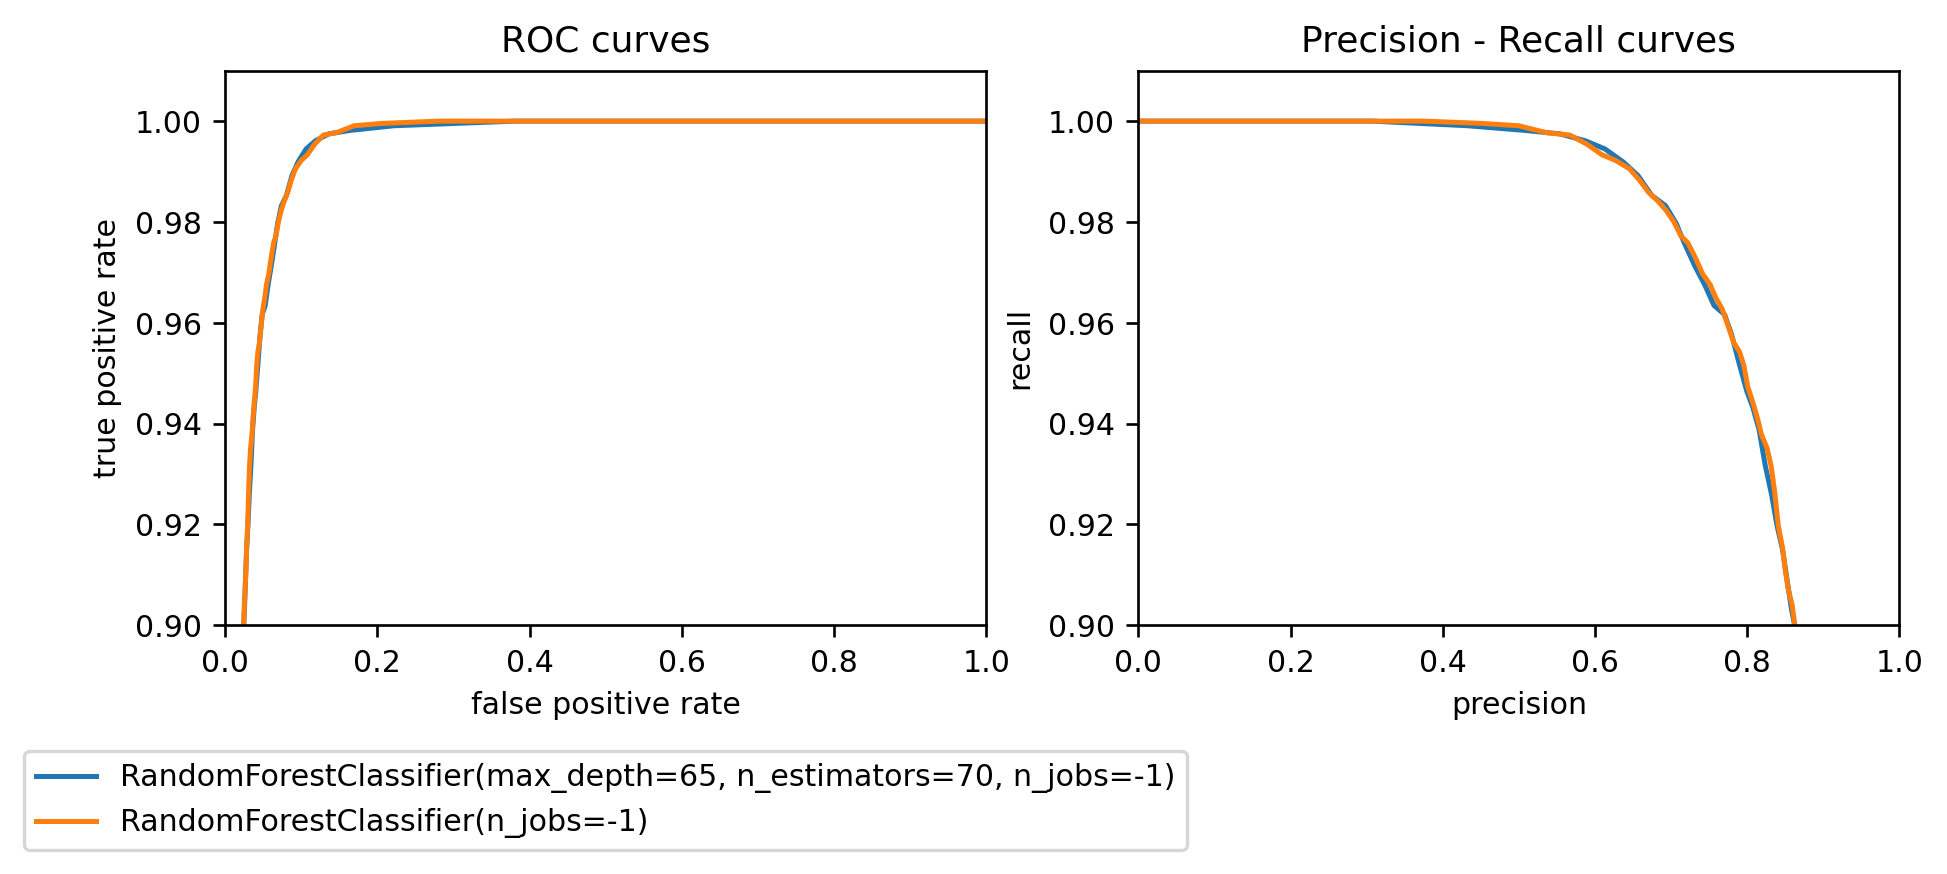

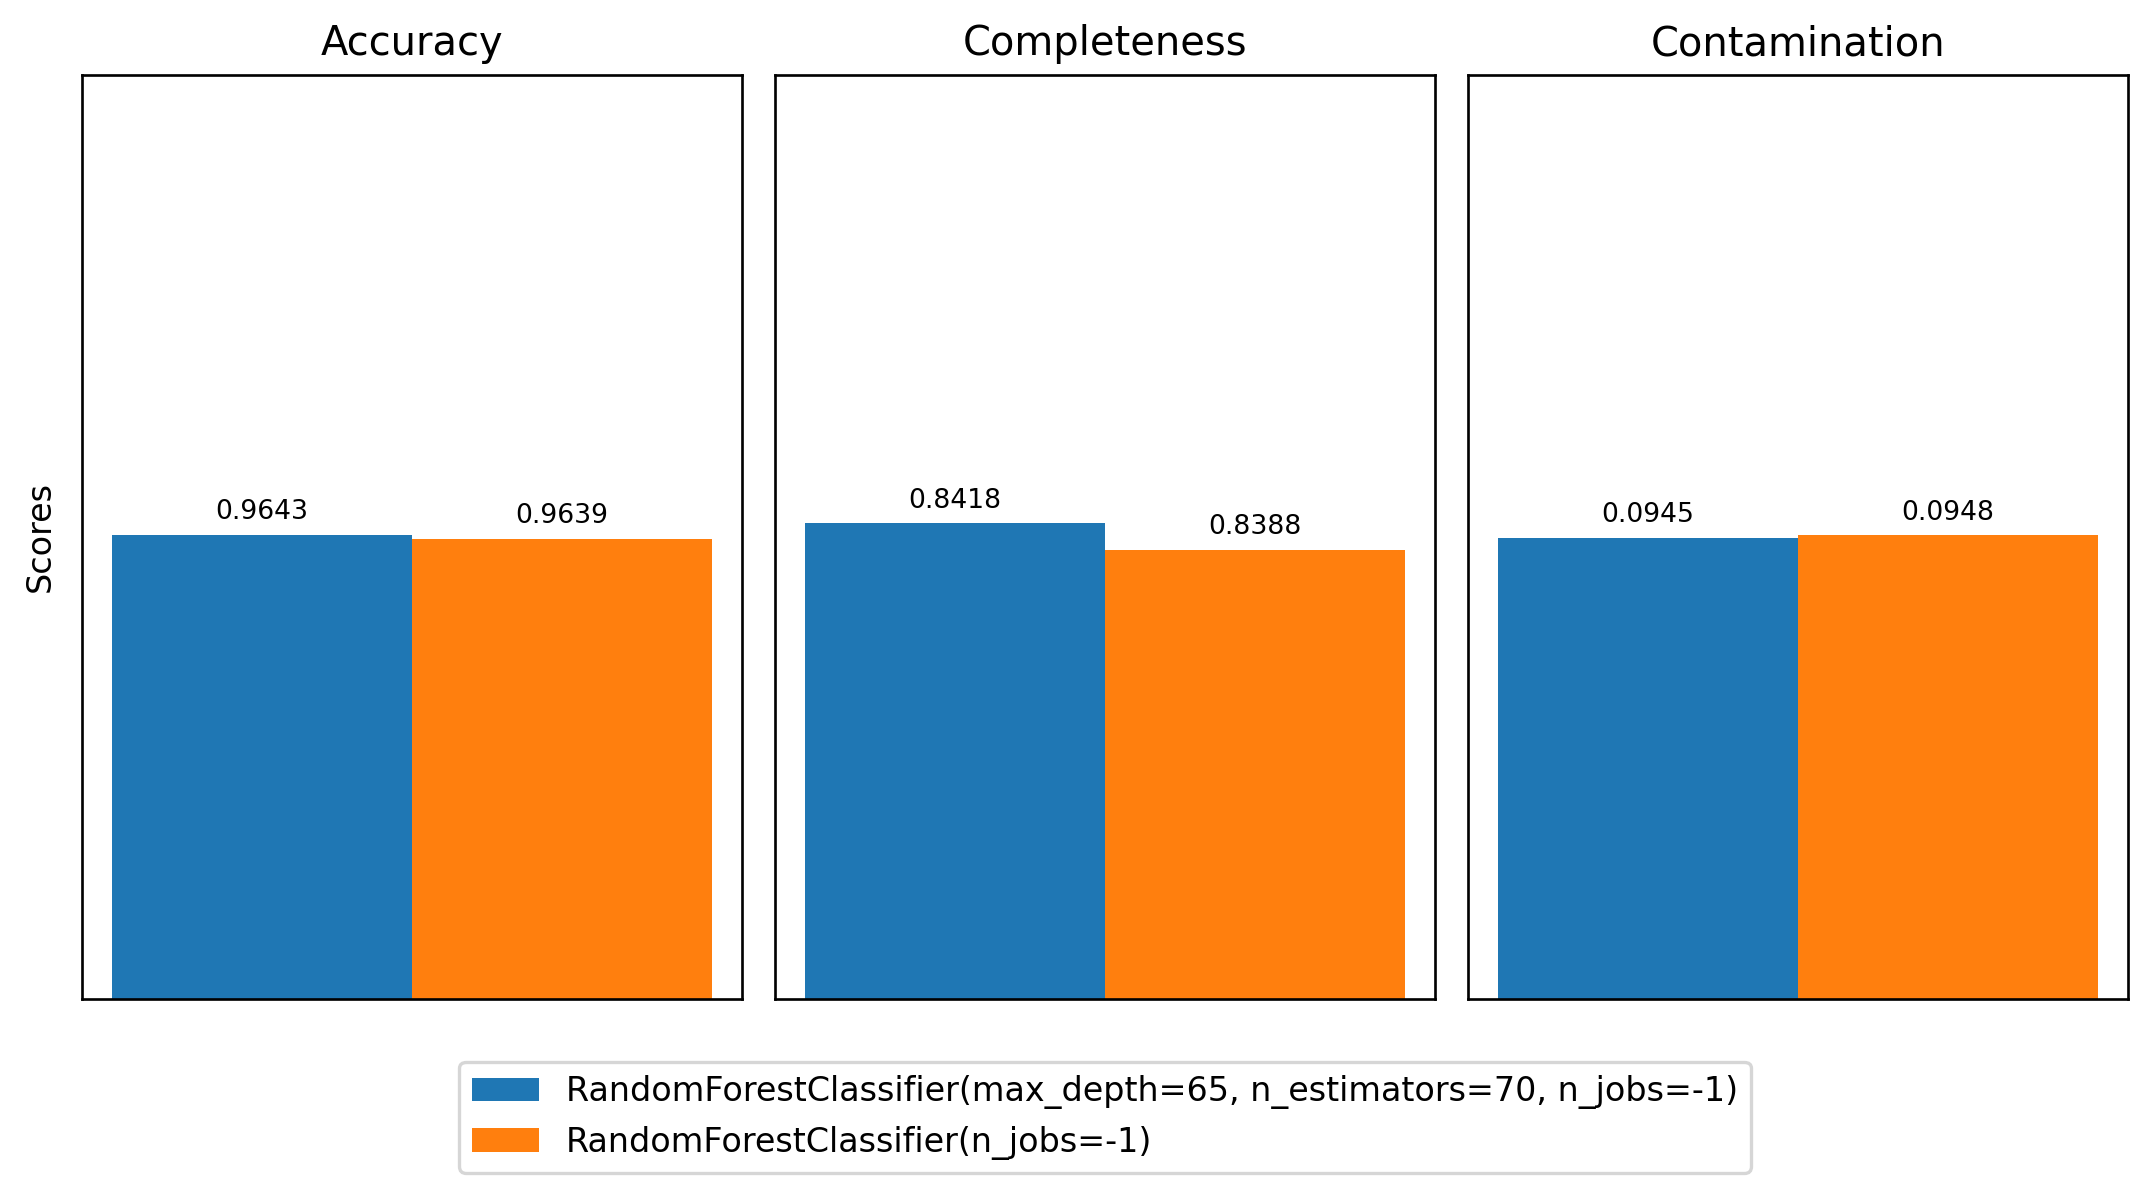

In [109]:
# Compare classifier with cross-validated parameters vs base one
info_list_rdf = [info_rdf_CV] + [info_rdf]

a_rdf = compare_classifiers(info_list_rdf)

Slight improvement with CV